In [1]:
import flair
import matplotlib.pyplot as plt
import os
import pandas as pd

from codealltag_data_processor_v2025 import CodealltagDataProcessor
from flair.data import Corpus, Dictionary, Sentence
from flair.datasets import ColumnCorpus
from flair.embeddings import (
    BytePairEmbeddings,
    CharacterEmbeddings,
    StackedEmbeddings,
    TokenEmbeddings
)
from flair.models import SequenceTagger
from flair.nn import Model
from flair.trainers import ModelTrainer
from pathlib import Path

In [2]:
flair.cache_root = Path(os.path.join(*['/home', 's81481', '.flair']))

In [3]:
cdp_2022 = CodealltagDataProcessor(data_version='20220513', config_path=['codealltag_data_processor.yml'])

In [4]:
sample_df = pd.read_csv("data_utility_dataset_3500.csv", index_col=0)

In [5]:
k = 10

In [6]:
dataset = cdp_2022.get_train_dev_test_datasetdict_for_sample_df_10_8_2(sample_df, test_data_count=1000, k=k)

In [7]:
model_dir_path = os.path.join(*["logs", "PDUC", "PSEU", "BiLSTM_CRF", "NER", str(len(sample_df)), "k"+str(k)])
os.makedirs(model_dir_path, exist_ok=True)

In [8]:
tmp_data_dir = Path("tmp_data_dir")
tmp_data_dir.mkdir(parents=True, exist_ok=True)
for file in tmp_data_dir.glob("*"):
    if file.is_file():
        file.unlink()

In [9]:
train_df = dataset["train"].to_pandas()
dev_df = dataset["dev"].to_pandas()
test_df = dataset["test"].to_pandas()

In [10]:
train_text = train_df.MT5PTTL.str.cat(sep="\n")
dev_text = dev_df.MT5PTTL.str.cat(sep="\n")
test_text = test_df.OTTL.str.cat(sep="\n")

In [11]:
with open(os.path.join(tmp_data_dir, "train.txt"), "w", encoding="utf-8") as writer:        
    writer.write(train_text)

with open(os.path.join(tmp_data_dir, "dev.txt"), "w", encoding="utf-8") as writer:        
    writer.write(dev_text)
    
with open(os.path.join(tmp_data_dir, "test.txt"), "w", encoding="utf-8") as writer:        
    writer.write(test_text)

In [12]:
!ls -la tmp_data_dir

total 1505
drwxr-xr-x 2 root root      3 Mar  7 14:09 .
drwxr-xr-x 8 root root     56 Mar  7 14:08 ..
-rw-r--r-- 1 root root 223682 Mar  7 14:09 dev.txt
-rw-r--r-- 1 root root 434966 Mar  7 14:09 test.txt
-rw-r--r-- 1 root root 881221 Mar  7 14:09 train.txt


In [13]:
corpus: Corpus = ColumnCorpus(tmp_data_dir, {0: 'text', 1: 'ner'})

2025-03-07 14:09:39,117 Reading data from tmp_data_dir
2025-03-07 14:09:39,118 Train: tmp_data_dir/train.txt
2025-03-07 14:09:39,118 Dev: tmp_data_dir/dev.txt
2025-03-07 14:09:39,119 Test: tmp_data_dir/test.txt


In [14]:
label_dict: Dictionary = corpus.make_label_dictionary(label_type="ner")

2025-03-07 14:09:41,673 Computing label dictionary. Progress:


2000it [00:00, 26592.01it/s]

2025-03-07 14:09:41,863 Dictionary created for label 'ner' with 15 values: MALE (seen 1699 times), FAMILY (seen 1358 times), FEMALE (seen 1316 times), URL (seen 900 times), CITY (seen 815 times), PHONE (seen 491 times), STREET (seen 464 times), EMAIL (seen 445 times), ZIP (seen 444 times), STREETNO (seen 435 times), DATE (seen 300 times), ORG (seen 265 times), UFID (seen 128 times), USER (seen 128 times)


In [15]:
print(label_dict.idx2item)

[b'<unk>', b'MALE', b'FAMILY', b'FEMALE', b'URL', b'CITY', b'PHONE', b'STREET', b'EMAIL', b'ZIP', b'STREETNO', b'DATE', b'ORG', b'UFID', b'USER']


In [16]:
embeddings: TokenEmbeddings = StackedEmbeddings(
    [
        BytePairEmbeddings("de"),
        CharacterEmbeddings()
    ]
)

In [17]:
tagger: SequenceTagger = SequenceTagger(
    hidden_size=256,
    embeddings=embeddings,
    tag_dictionary=label_dict,
    tag_type="ner",
    use_crf=True,
    use_rnn=True,
    reproject_embeddings=True
)
tagger.label_dictionary.add_unk = True

2025-03-07 14:09:44,849 SequenceTagger predicts: Dictionary with 57 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-FEMALE, B-FEMALE, E-FEMALE, I-FEMALE, S-URL, B-URL, E-URL, I-URL, S-CITY, B-CITY, E-CITY, I-CITY, S-PHONE, B-PHONE, E-PHONE, I-PHONE, S-STREET, B-STREET, E-STREET, I-STREET, S-EMAIL, B-EMAIL, E-EMAIL, I-EMAIL, S-ZIP, B-ZIP, E-ZIP, I-ZIP, S-STREETNO, B-STREETNO, E-STREETNO, I-STREETNO, S-DATE, B-DATE, E-DATE, I-DATE, S-ORG, B-ORG, E-ORG, I-ORG, S-UFID


In [18]:
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

In [19]:
trainer.train(
    model_dir_path,
    learning_rate=0.1,
    mini_batch_size=16,
    max_epochs=100,
    checkpoint=True,
    write_weights=True,
    use_tensorboard=True,
    tensorboard_log_dir=model_dir_path
)

2025-03-07 14:09:45,175 tensorboard logging path is logs/PDUC/PSEU/BiLSTM_CRF/NER/3500/k10
2025-03-07 14:09:53,688 ----------------------------------------------------------------------------------------------------
2025-03-07 14:09:53,689 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): BytePairEmbeddings(model=0-bpe-de-100000-50)
    (list_embedding_1): CharacterEmbeddings(
      (char_embedding): Embedding(275, 25)
      (char_rnn): LSTM(25, 25, bidirectional=True)
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=150, out_features=150, bias=True)
  (rnn): LSTM(150, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=59, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)"
2025-03-07 14:09:53,689 ----------------------------------------------------------------------------------------------------
2025-03-07 14:09:53,689 Corpus:

100%|███████████████████████████████████████████| 32/32 [00:09<00:00,  3.31it/s]

2025-03-07 14:11:08,414 Evaluating as a multi-label problem: False
2025-03-07 14:11:08,434 DEV : loss 0.3204362094402313 - f1-score (micro avg)  0.4013


2025-03-07 14:11:08,603 BAD EPOCHS (no improvement): 0
2025-03-07 14:11:08,873 saving best model
2025-03-07 14:11:09,080 ----------------------------------------------------------------------------------------------------
2025-03-07 14:11:14,704 epoch 2 - iter 12/125 - loss 0.32937378 - samples/sec: 34.17 - lr: 0.100000
2025-03-07 14:11:20,204 epoch 2 - iter 24/125 - loss 0.30942802 - samples/sec: 35.14 - lr: 0.100000
2025-03-07 14:11:25,921 epoch 2 - iter 36/125 - loss 0.28112351 - samples/sec: 33.69 - lr: 0.100000
2025-03-07 14:11:31,618 epoch 2 - iter 48/125 - loss 0.27489841 - samples/sec: 33.81 - lr: 0.100000
2025-03-07 14:11:36,989 epoch 2 - iter 60/125 - loss 0.26895463 - samples/sec: 35.86 - lr: 0.100000
2025-03-07 14:11:42,362 epoch 2 - iter 72/125 - loss 0.26185805 - samples/sec: 35.85 - lr: 0.100000
2025-03-07 14:11:47,633 epoch 2 - iter 84/125 - loss 0.25510305 - samples/sec: 36.57 - lr: 0.100000
2025-03-07 14:11:53,661 epoch 2 - iter 96/125 - loss 0.24580683 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 14:12:15,480 Evaluating as a multi-label problem: False
2025-03-07 14:12:15,500 DEV : loss 0.14431193470954895 - f1-score (micro avg)  0.7829


2025-03-07 14:12:15,651 BAD EPOCHS (no improvement): 0
2025-03-07 14:12:15,866 saving best model
2025-03-07 14:12:16,064 ----------------------------------------------------------------------------------------------------
2025-03-07 14:12:21,791 epoch 3 - iter 12/125 - loss 0.17968630 - samples/sec: 33.54 - lr: 0.100000
2025-03-07 14:12:27,174 epoch 3 - iter 24/125 - loss 0.17716060 - samples/sec: 35.80 - lr: 0.100000
2025-03-07 14:12:32,669 epoch 3 - iter 36/125 - loss 0.18121264 - samples/sec: 35.06 - lr: 0.100000
2025-03-07 14:12:37,977 epoch 3 - iter 48/125 - loss 0.17669399 - samples/sec: 36.28 - lr: 0.100000
2025-03-07 14:12:43,409 epoch 3 - iter 60/125 - loss 0.17128113 - samples/sec: 35.47 - lr: 0.100000
2025-03-07 14:12:49,189 epoch 3 - iter 72/125 - loss 0.16670449 - samples/sec: 33.32 - lr: 0.100000
2025-03-07 14:12:54,795 epoch 3 - iter 84/125 - loss 0.16312999 - samples/sec: 34.38 - lr: 0.100000
2025-03-07 14:13:00,323 epoch 3 - iter 96/125 - loss 0.16597092 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.71it/s]

2025-03-07 14:13:22,820 Evaluating as a multi-label problem: False
2025-03-07 14:13:22,840 DEV : loss 0.10063876211643219 - f1-score (micro avg)  0.8404


2025-03-07 14:13:22,984 BAD EPOCHS (no improvement): 0
2025-03-07 14:13:23,202 saving best model
2025-03-07 14:13:23,401 ----------------------------------------------------------------------------------------------------
2025-03-07 14:13:28,884 epoch 4 - iter 12/125 - loss 0.12910987 - samples/sec: 35.03 - lr: 0.100000
2025-03-07 14:13:34,434 epoch 4 - iter 24/125 - loss 0.13755620 - samples/sec: 34.73 - lr: 0.100000
2025-03-07 14:13:39,691 epoch 4 - iter 36/125 - loss 0.13831968 - samples/sec: 36.64 - lr: 0.100000
2025-03-07 14:13:45,924 epoch 4 - iter 48/125 - loss 0.13202765 - samples/sec: 30.89 - lr: 0.100000
2025-03-07 14:13:51,550 epoch 4 - iter 60/125 - loss 0.13952731 - samples/sec: 34.23 - lr: 0.100000
2025-03-07 14:13:56,826 epoch 4 - iter 72/125 - loss 0.13811905 - samples/sec: 36.51 - lr: 0.100000
2025-03-07 14:14:02,020 epoch 4 - iter 84/125 - loss 0.13683579 - samples/sec: 37.11 - lr: 0.100000
2025-03-07 14:14:07,705 epoch 4 - iter 96/125 - loss 0.13602214 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]

2025-03-07 14:14:29,936 Evaluating as a multi-label problem: False
2025-03-07 14:14:29,957 DEV : loss 0.087554432451725 - f1-score (micro avg)  0.855


2025-03-07 14:14:30,086 BAD EPOCHS (no improvement): 0
2025-03-07 14:14:30,291 saving best model
2025-03-07 14:14:30,487 ----------------------------------------------------------------------------------------------------
2025-03-07 14:14:35,926 epoch 5 - iter 12/125 - loss 0.12317764 - samples/sec: 35.32 - lr: 0.100000
2025-03-07 14:14:41,597 epoch 5 - iter 24/125 - loss 0.11937270 - samples/sec: 33.98 - lr: 0.100000
2025-03-07 14:14:47,348 epoch 5 - iter 36/125 - loss 0.11158345 - samples/sec: 33.48 - lr: 0.100000
2025-03-07 14:14:53,037 epoch 5 - iter 48/125 - loss 0.11267702 - samples/sec: 33.86 - lr: 0.100000
2025-03-07 14:14:58,069 epoch 5 - iter 60/125 - loss 0.11304950 - samples/sec: 38.28 - lr: 0.100000
2025-03-07 14:15:03,734 epoch 5 - iter 72/125 - loss 0.11785180 - samples/sec: 34.00 - lr: 0.100000
2025-03-07 14:15:09,382 epoch 5 - iter 84/125 - loss 0.11787479 - samples/sec: 34.12 - lr: 0.100000
2025-03-07 14:15:14,751 epoch 5 - iter 96/125 - loss 0.11608255 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 14:15:36,491 Evaluating as a multi-label problem: False
2025-03-07 14:15:36,512 DEV : loss 0.07260902225971222 - f1-score (micro avg)  0.868


2025-03-07 14:15:36,638 BAD EPOCHS (no improvement): 0
2025-03-07 14:15:36,857 saving best model
2025-03-07 14:15:37,062 ----------------------------------------------------------------------------------------------------
2025-03-07 14:15:42,223 epoch 6 - iter 12/125 - loss 0.10116734 - samples/sec: 37.22 - lr: 0.100000
2025-03-07 14:15:47,677 epoch 6 - iter 24/125 - loss 0.09738819 - samples/sec: 35.33 - lr: 0.100000
2025-03-07 14:15:53,165 epoch 6 - iter 36/125 - loss 0.09889069 - samples/sec: 35.11 - lr: 0.100000
2025-03-07 14:15:59,071 epoch 6 - iter 48/125 - loss 0.09700798 - samples/sec: 32.60 - lr: 0.100000
2025-03-07 14:16:04,729 epoch 6 - iter 60/125 - loss 0.09995731 - samples/sec: 34.04 - lr: 0.100000
2025-03-07 14:16:10,448 epoch 6 - iter 72/125 - loss 0.10065823 - samples/sec: 33.67 - lr: 0.100000
2025-03-07 14:16:15,806 epoch 6 - iter 84/125 - loss 0.10256960 - samples/sec: 35.95 - lr: 0.100000
2025-03-07 14:16:21,246 epoch 6 - iter 96/125 - loss 0.10161853 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.78it/s]

2025-03-07 14:16:43,015 Evaluating as a multi-label problem: False
2025-03-07 14:16:43,035 DEV : loss 0.06337866932153702 - f1-score (micro avg)  0.8943


2025-03-07 14:16:43,159 BAD EPOCHS (no improvement): 0
2025-03-07 14:16:43,378 saving best model
2025-03-07 14:16:43,578 ----------------------------------------------------------------------------------------------------
2025-03-07 14:16:49,096 epoch 7 - iter 12/125 - loss 0.09354359 - samples/sec: 34.81 - lr: 0.100000
2025-03-07 14:16:54,929 epoch 7 - iter 24/125 - loss 0.09734412 - samples/sec: 33.03 - lr: 0.100000
2025-03-07 14:17:00,427 epoch 7 - iter 36/125 - loss 0.09098843 - samples/sec: 35.04 - lr: 0.100000
2025-03-07 14:17:06,285 epoch 7 - iter 48/125 - loss 0.09125603 - samples/sec: 32.87 - lr: 0.100000
2025-03-07 14:17:11,748 epoch 7 - iter 60/125 - loss 0.09225730 - samples/sec: 35.26 - lr: 0.100000
2025-03-07 14:17:17,202 epoch 7 - iter 72/125 - loss 0.09263906 - samples/sec: 35.31 - lr: 0.100000
2025-03-07 14:17:23,000 epoch 7 - iter 84/125 - loss 0.09275353 - samples/sec: 33.23 - lr: 0.100000
2025-03-07 14:17:28,487 epoch 7 - iter 96/125 - loss 0.09176663 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.69it/s]

2025-03-07 14:17:50,374 Evaluating as a multi-label problem: False
2025-03-07 14:17:50,395 DEV : loss 0.0597342774271965 - f1-score (micro avg)  0.9035


2025-03-07 14:17:50,538 BAD EPOCHS (no improvement): 0
2025-03-07 14:17:50,750 saving best model
2025-03-07 14:17:50,950 ----------------------------------------------------------------------------------------------------
2025-03-07 14:17:56,478 epoch 8 - iter 12/125 - loss 0.09874931 - samples/sec: 34.75 - lr: 0.100000
2025-03-07 14:18:02,071 epoch 8 - iter 24/125 - loss 0.09475194 - samples/sec: 34.45 - lr: 0.100000
2025-03-07 14:18:07,553 epoch 8 - iter 36/125 - loss 0.09615226 - samples/sec: 35.14 - lr: 0.100000
2025-03-07 14:18:13,397 epoch 8 - iter 48/125 - loss 0.09129329 - samples/sec: 32.95 - lr: 0.100000
2025-03-07 14:18:18,795 epoch 8 - iter 60/125 - loss 0.09535443 - samples/sec: 35.68 - lr: 0.100000
2025-03-07 14:18:24,561 epoch 8 - iter 72/125 - loss 0.09412721 - samples/sec: 33.40 - lr: 0.100000
2025-03-07 14:18:29,912 epoch 8 - iter 84/125 - loss 0.09091830 - samples/sec: 35.99 - lr: 0.100000
2025-03-07 14:18:34,977 epoch 8 - iter 96/125 - loss 0.09004288 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.95it/s]

2025-03-07 14:18:57,045 Evaluating as a multi-label problem: False
2025-03-07 14:18:57,066 DEV : loss 0.0529920719563961 - f1-score (micro avg)  0.9145


2025-03-07 14:18:57,227 BAD EPOCHS (no improvement): 0
2025-03-07 14:18:57,446 saving best model
2025-03-07 14:18:57,645 ----------------------------------------------------------------------------------------------------
2025-03-07 14:19:03,092 epoch 9 - iter 12/125 - loss 0.08150499 - samples/sec: 35.27 - lr: 0.100000
2025-03-07 14:19:08,449 epoch 9 - iter 24/125 - loss 0.08207600 - samples/sec: 36.00 - lr: 0.100000
2025-03-07 14:19:14,131 epoch 9 - iter 36/125 - loss 0.07973934 - samples/sec: 33.90 - lr: 0.100000
2025-03-07 14:19:19,527 epoch 9 - iter 48/125 - loss 0.07910656 - samples/sec: 35.69 - lr: 0.100000
2025-03-07 14:19:25,242 epoch 9 - iter 60/125 - loss 0.07839474 - samples/sec: 33.70 - lr: 0.100000
2025-03-07 14:19:30,662 epoch 9 - iter 72/125 - loss 0.07870784 - samples/sec: 35.54 - lr: 0.100000
2025-03-07 14:19:36,297 epoch 9 - iter 84/125 - loss 0.07962991 - samples/sec: 34.19 - lr: 0.100000
2025-03-07 14:19:42,076 epoch 9 - iter 96/125 - loss 0.07920883 - samples/sec:

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.67it/s]


2025-03-07 14:20:04,145 Evaluating as a multi-label problem: False
2025-03-07 14:20:04,166 DEV : loss 0.05291857197880745 - f1-score (micro avg)  0.9146
2025-03-07 14:20:04,335 BAD EPOCHS (no improvement): 0
2025-03-07 14:20:04,553 saving best model
2025-03-07 14:20:04,758 ----------------------------------------------------------------------------------------------------
2025-03-07 14:20:10,899 epoch 10 - iter 12/125 - loss 0.06742525 - samples/sec: 31.29 - lr: 0.100000
2025-03-07 14:20:16,463 epoch 10 - iter 24/125 - loss 0.07319077 - samples/sec: 34.64 - lr: 0.100000
2025-03-07 14:20:21,730 epoch 10 - iter 36/125 - loss 0.07798077 - samples/sec: 36.59 - lr: 0.100000
2025-03-07 14:20:26,961 epoch 10 - iter 48/125 - loss 0.07738345 - samples/sec: 36.84 - lr: 0.100000
2025-03-07 14:20:32,348 epoch 10 - iter 60/125 - loss 0.07719060 - samples/sec: 35.77 - lr: 0.100000
2025-03-07 14:20:37,850 epoch 10 - iter 72/125 - loss 0.07925019 - samples/sec: 35.04 - lr: 0.100000
2025-03-07 14:20:43

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.68it/s]

2025-03-07 14:21:12,479 Evaluating as a multi-label problem: False
2025-03-07 14:21:12,499 DEV : loss 0.04870200529694557 - f1-score (micro avg)  0.9248


2025-03-07 14:21:12,643 BAD EPOCHS (no improvement): 0
2025-03-07 14:21:12,866 saving best model
2025-03-07 14:21:13,066 ----------------------------------------------------------------------------------------------------
2025-03-07 14:21:18,533 epoch 11 - iter 12/125 - loss 0.06855363 - samples/sec: 35.13 - lr: 0.100000
2025-03-07 14:21:23,719 epoch 11 - iter 24/125 - loss 0.07832221 - samples/sec: 37.20 - lr: 0.100000
2025-03-07 14:21:29,065 epoch 11 - iter 36/125 - loss 0.07672928 - samples/sec: 36.02 - lr: 0.100000
2025-03-07 14:21:34,901 epoch 11 - iter 48/125 - loss 0.07500531 - samples/sec: 33.00 - lr: 0.100000
2025-03-07 14:21:40,495 epoch 11 - iter 60/125 - loss 0.07497159 - samples/sec: 34.43 - lr: 0.100000
2025-03-07 14:21:45,933 epoch 11 - iter 72/125 - loss 0.07343936 - samples/sec: 35.42 - lr: 0.100000
2025-03-07 14:21:51,139 epoch 11 - iter 84/125 - loss 0.07379602 - samples/sec: 37.02 - lr: 0.100000
2025-03-07 14:21:56,843 epoch 11 - iter 96/125 - loss 0.07450311 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 14:22:18,751 Evaluating as a multi-label problem: False
2025-03-07 14:22:18,772 DEV : loss 0.04713412746787071 - f1-score (micro avg)  0.9236


2025-03-07 14:22:18,913 BAD EPOCHS (no improvement): 1
2025-03-07 14:22:19,126 ----------------------------------------------------------------------------------------------------
2025-03-07 14:22:24,592 epoch 12 - iter 12/125 - loss 0.06269279 - samples/sec: 35.15 - lr: 0.100000
2025-03-07 14:22:30,244 epoch 12 - iter 24/125 - loss 0.07112348 - samples/sec: 34.85 - lr: 0.100000
2025-03-07 14:22:35,580 epoch 12 - iter 36/125 - loss 0.07345532 - samples/sec: 36.11 - lr: 0.100000
2025-03-07 14:22:41,132 epoch 12 - iter 48/125 - loss 0.07386595 - samples/sec: 34.70 - lr: 0.100000
2025-03-07 14:22:46,529 epoch 12 - iter 60/125 - loss 0.07193161 - samples/sec: 35.69 - lr: 0.100000
2025-03-07 14:22:52,299 epoch 12 - iter 72/125 - loss 0.07086037 - samples/sec: 33.38 - lr: 0.100000
2025-03-07 14:22:57,606 epoch 12 - iter 84/125 - loss 0.07174070 - samples/sec: 36.33 - lr: 0.100000
2025-03-07 14:23:03,460 epoch 12 - iter 96/125 - loss 0.07144523 - samples/sec: 32.98 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]

2025-03-07 14:23:25,902 Evaluating as a multi-label problem: False
2025-03-07 14:23:25,921 DEV : loss 0.04712393134832382 - f1-score (micro avg)  0.9255


2025-03-07 14:23:26,047 BAD EPOCHS (no improvement): 0
2025-03-07 14:23:26,265 saving best model
2025-03-07 14:23:26,464 ----------------------------------------------------------------------------------------------------
2025-03-07 14:23:31,921 epoch 13 - iter 12/125 - loss 0.07617256 - samples/sec: 35.20 - lr: 0.100000
2025-03-07 14:23:37,494 epoch 13 - iter 24/125 - loss 0.06940851 - samples/sec: 34.57 - lr: 0.100000
2025-03-07 14:23:43,175 epoch 13 - iter 36/125 - loss 0.07162470 - samples/sec: 33.90 - lr: 0.100000
2025-03-07 14:23:48,906 epoch 13 - iter 48/125 - loss 0.07153610 - samples/sec: 33.60 - lr: 0.100000
2025-03-07 14:23:54,692 epoch 13 - iter 60/125 - loss 0.07100842 - samples/sec: 33.28 - lr: 0.100000
2025-03-07 14:24:00,152 epoch 13 - iter 72/125 - loss 0.07239300 - samples/sec: 35.28 - lr: 0.100000
2025-03-07 14:24:06,197 epoch 13 - iter 84/125 - loss 0.07041115 - samples/sec: 31.87 - lr: 0.100000
2025-03-07 14:24:11,853 epoch 13 - iter 96/125 - loss 0.06939094 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 14:24:33,134 Evaluating as a multi-label problem: False
2025-03-07 14:24:33,154 DEV : loss 0.04707740247249603 - f1-score (micro avg)  0.9216


2025-03-07 14:24:33,286 BAD EPOCHS (no improvement): 1
2025-03-07 14:24:33,505 ----------------------------------------------------------------------------------------------------
2025-03-07 14:24:38,976 epoch 14 - iter 12/125 - loss 0.05456213 - samples/sec: 35.11 - lr: 0.100000
2025-03-07 14:24:44,521 epoch 14 - iter 24/125 - loss 0.06125991 - samples/sec: 34.75 - lr: 0.100000
2025-03-07 14:24:50,120 epoch 14 - iter 36/125 - loss 0.06131913 - samples/sec: 34.41 - lr: 0.100000
2025-03-07 14:24:55,719 epoch 14 - iter 48/125 - loss 0.06112907 - samples/sec: 34.40 - lr: 0.100000
2025-03-07 14:25:01,053 epoch 14 - iter 60/125 - loss 0.06476885 - samples/sec: 36.11 - lr: 0.100000
2025-03-07 14:25:06,487 epoch 14 - iter 72/125 - loss 0.06583827 - samples/sec: 35.44 - lr: 0.100000
2025-03-07 14:25:11,591 epoch 14 - iter 84/125 - loss 0.06453077 - samples/sec: 37.74 - lr: 0.100000
2025-03-07 14:25:17,140 epoch 14 - iter 96/125 - loss 0.06452289 - samples/sec: 34.71 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 14:25:39,192 Evaluating as a multi-label problem: False
2025-03-07 14:25:39,213 DEV : loss 0.04733870178461075 - f1-score (micro avg)  0.9258


2025-03-07 14:25:39,344 BAD EPOCHS (no improvement): 0
2025-03-07 14:25:39,574 saving best model
2025-03-07 14:25:39,790 ----------------------------------------------------------------------------------------------------
2025-03-07 14:25:45,058 epoch 15 - iter 12/125 - loss 0.05521897 - samples/sec: 36.46 - lr: 0.100000
2025-03-07 14:25:50,553 epoch 15 - iter 24/125 - loss 0.06161317 - samples/sec: 35.07 - lr: 0.100000
2025-03-07 14:25:56,098 epoch 15 - iter 36/125 - loss 0.05885029 - samples/sec: 34.73 - lr: 0.100000
2025-03-07 14:26:01,571 epoch 15 - iter 48/125 - loss 0.05920799 - samples/sec: 35.20 - lr: 0.100000
2025-03-07 14:26:07,020 epoch 15 - iter 60/125 - loss 0.06017033 - samples/sec: 35.34 - lr: 0.100000
2025-03-07 14:26:12,429 epoch 15 - iter 72/125 - loss 0.06081003 - samples/sec: 35.62 - lr: 0.100000
2025-03-07 14:26:18,321 epoch 15 - iter 84/125 - loss 0.06166171 - samples/sec: 32.69 - lr: 0.100000
2025-03-07 14:26:23,755 epoch 15 - iter 96/125 - loss 0.06103223 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]

2025-03-07 14:26:45,797 Evaluating as a multi-label problem: False
2025-03-07 14:26:45,817 DEV : loss 0.044051945209503174 - f1-score (micro avg)  0.9287


2025-03-07 14:26:45,947 BAD EPOCHS (no improvement): 0
2025-03-07 14:26:46,170 saving best model
2025-03-07 14:26:46,384 ----------------------------------------------------------------------------------------------------
2025-03-07 14:26:51,964 epoch 16 - iter 12/125 - loss 0.06898148 - samples/sec: 34.43 - lr: 0.100000
2025-03-07 14:26:57,573 epoch 16 - iter 24/125 - loss 0.07143231 - samples/sec: 34.42 - lr: 0.100000
2025-03-07 14:27:03,021 epoch 16 - iter 36/125 - loss 0.06728995 - samples/sec: 35.35 - lr: 0.100000
2025-03-07 14:27:08,683 epoch 16 - iter 48/125 - loss 0.06577679 - samples/sec: 34.01 - lr: 0.100000
2025-03-07 14:27:14,033 epoch 16 - iter 60/125 - loss 0.06434284 - samples/sec: 36.00 - lr: 0.100000
2025-03-07 14:27:19,531 epoch 16 - iter 72/125 - loss 0.06319590 - samples/sec: 35.03 - lr: 0.100000
2025-03-07 14:27:24,961 epoch 16 - iter 84/125 - loss 0.06225276 - samples/sec: 35.47 - lr: 0.100000
2025-03-07 14:27:30,838 epoch 16 - iter 96/125 - loss 0.06197420 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]

2025-03-07 14:27:52,952 Evaluating as a multi-label problem: False
2025-03-07 14:27:52,972 DEV : loss 0.04186359792947769 - f1-score (micro avg)  0.9354


2025-03-07 14:27:53,108 BAD EPOCHS (no improvement): 0
2025-03-07 14:27:53,329 saving best model
2025-03-07 14:27:53,526 ----------------------------------------------------------------------------------------------------
2025-03-07 14:27:58,978 epoch 17 - iter 12/125 - loss 0.05924571 - samples/sec: 35.24 - lr: 0.100000
2025-03-07 14:28:04,611 epoch 17 - iter 24/125 - loss 0.05605283 - samples/sec: 34.50 - lr: 0.100000
2025-03-07 14:28:10,112 epoch 17 - iter 36/125 - loss 0.05548107 - samples/sec: 35.02 - lr: 0.100000
2025-03-07 14:28:15,743 epoch 17 - iter 48/125 - loss 0.05651906 - samples/sec: 34.20 - lr: 0.100000
2025-03-07 14:28:21,289 epoch 17 - iter 60/125 - loss 0.05951943 - samples/sec: 34.73 - lr: 0.100000
2025-03-07 14:28:27,157 epoch 17 - iter 72/125 - loss 0.05862146 - samples/sec: 32.82 - lr: 0.100000
2025-03-07 14:28:32,417 epoch 17 - iter 84/125 - loss 0.05864813 - samples/sec: 36.62 - lr: 0.100000
2025-03-07 14:28:38,264 epoch 17 - iter 96/125 - loss 0.05790697 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]

2025-03-07 14:28:59,408 Evaluating as a multi-label problem: False
2025-03-07 14:28:59,428 DEV : loss 0.04118452966213226 - f1-score (micro avg)  0.9326


2025-03-07 14:28:59,556 BAD EPOCHS (no improvement): 1
2025-03-07 14:28:59,770 ----------------------------------------------------------------------------------------------------
2025-03-07 14:29:05,319 epoch 18 - iter 12/125 - loss 0.06472290 - samples/sec: 34.62 - lr: 0.100000
2025-03-07 14:29:11,241 epoch 18 - iter 24/125 - loss 0.06061811 - samples/sec: 32.52 - lr: 0.100000
2025-03-07 14:29:17,002 epoch 18 - iter 36/125 - loss 0.05676900 - samples/sec: 33.43 - lr: 0.100000
2025-03-07 14:29:22,282 epoch 18 - iter 48/125 - loss 0.05845071 - samples/sec: 36.48 - lr: 0.100000
2025-03-07 14:29:27,691 epoch 18 - iter 60/125 - loss 0.05667197 - samples/sec: 35.61 - lr: 0.100000
2025-03-07 14:29:33,081 epoch 18 - iter 72/125 - loss 0.05973483 - samples/sec: 35.72 - lr: 0.100000
2025-03-07 14:29:38,503 epoch 18 - iter 84/125 - loss 0.05832981 - samples/sec: 35.63 - lr: 0.100000
2025-03-07 14:29:44,241 epoch 18 - iter 96/125 - loss 0.05801079 - samples/sec: 33.58 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.69it/s]

2025-03-07 14:30:06,391 Evaluating as a multi-label problem: False
2025-03-07 14:30:06,412 DEV : loss 0.04144987091422081 - f1-score (micro avg)  0.9325


2025-03-07 14:30:06,578 BAD EPOCHS (no improvement): 2
2025-03-07 14:30:06,806 ----------------------------------------------------------------------------------------------------
2025-03-07 14:30:12,769 epoch 19 - iter 12/125 - loss 0.04796380 - samples/sec: 32.22 - lr: 0.100000
2025-03-07 14:30:18,540 epoch 19 - iter 24/125 - loss 0.05219991 - samples/sec: 33.39 - lr: 0.100000
2025-03-07 14:30:24,220 epoch 19 - iter 36/125 - loss 0.05170346 - samples/sec: 33.91 - lr: 0.100000
2025-03-07 14:30:29,398 epoch 19 - iter 48/125 - loss 0.05061852 - samples/sec: 37.20 - lr: 0.100000
2025-03-07 14:30:34,813 epoch 19 - iter 60/125 - loss 0.05303661 - samples/sec: 35.57 - lr: 0.100000
2025-03-07 14:30:39,943 epoch 19 - iter 72/125 - loss 0.05336811 - samples/sec: 37.55 - lr: 0.100000
2025-03-07 14:30:45,568 epoch 19 - iter 84/125 - loss 0.05505753 - samples/sec: 34.24 - lr: 0.100000
2025-03-07 14:30:50,915 epoch 19 - iter 96/125 - loss 0.05538280 - samples/sec: 36.05 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]

2025-03-07 14:31:13,158 Evaluating as a multi-label problem: False
2025-03-07 14:31:13,178 DEV : loss 0.038710370659828186 - f1-score (micro avg)  0.9364


2025-03-07 14:31:13,313 BAD EPOCHS (no improvement): 0
2025-03-07 14:31:13,555 saving best model
2025-03-07 14:31:13,754 ----------------------------------------------------------------------------------------------------
2025-03-07 14:31:19,773 epoch 20 - iter 12/125 - loss 0.05082484 - samples/sec: 31.91 - lr: 0.100000
2025-03-07 14:31:25,466 epoch 20 - iter 24/125 - loss 0.05169861 - samples/sec: 33.95 - lr: 0.100000
2025-03-07 14:31:31,015 epoch 20 - iter 36/125 - loss 0.05094022 - samples/sec: 34.71 - lr: 0.100000
2025-03-07 14:31:36,410 epoch 20 - iter 48/125 - loss 0.05380871 - samples/sec: 35.70 - lr: 0.100000
2025-03-07 14:31:41,945 epoch 20 - iter 60/125 - loss 0.05380104 - samples/sec: 34.80 - lr: 0.100000
2025-03-07 14:31:47,489 epoch 20 - iter 72/125 - loss 0.05361223 - samples/sec: 34.74 - lr: 0.100000
2025-03-07 14:31:53,044 epoch 20 - iter 84/125 - loss 0.05366732 - samples/sec: 34.69 - lr: 0.100000
2025-03-07 14:31:58,705 epoch 20 - iter 96/125 - loss 0.05382969 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 14:32:19,788 Evaluating as a multi-label problem: False
2025-03-07 14:32:19,809 DEV : loss 0.03901837393641472 - f1-score (micro avg)  0.9391


2025-03-07 14:32:19,932 BAD EPOCHS (no improvement): 0
2025-03-07 14:32:20,154 saving best model
2025-03-07 14:32:20,354 ----------------------------------------------------------------------------------------------------
2025-03-07 14:32:25,546 epoch 21 - iter 12/125 - loss 0.05469533 - samples/sec: 37.00 - lr: 0.100000
2025-03-07 14:32:31,411 epoch 21 - iter 24/125 - loss 0.04992475 - samples/sec: 32.93 - lr: 0.100000
2025-03-07 14:32:37,050 epoch 21 - iter 36/125 - loss 0.05042516 - samples/sec: 34.15 - lr: 0.100000
2025-03-07 14:32:42,568 epoch 21 - iter 48/125 - loss 0.04948115 - samples/sec: 34.90 - lr: 0.100000
2025-03-07 14:32:48,110 epoch 21 - iter 60/125 - loss 0.05024075 - samples/sec: 34.75 - lr: 0.100000
2025-03-07 14:32:53,712 epoch 21 - iter 72/125 - loss 0.04944336 - samples/sec: 34.38 - lr: 0.100000
2025-03-07 14:32:59,404 epoch 21 - iter 84/125 - loss 0.05066690 - samples/sec: 33.93 - lr: 0.100000
2025-03-07 14:33:04,828 epoch 21 - iter 96/125 - loss 0.05114107 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]

2025-03-07 14:33:26,833 Evaluating as a multi-label problem: False
2025-03-07 14:33:26,853 DEV : loss 0.0383865088224411 - f1-score (micro avg)  0.9345


2025-03-07 14:33:26,985 BAD EPOCHS (no improvement): 1
2025-03-07 14:33:27,213 ----------------------------------------------------------------------------------------------------
2025-03-07 14:33:32,715 epoch 22 - iter 12/125 - loss 0.05133356 - samples/sec: 34.91 - lr: 0.100000
2025-03-07 14:33:38,249 epoch 22 - iter 24/125 - loss 0.04938172 - samples/sec: 34.83 - lr: 0.100000
2025-03-07 14:33:43,523 epoch 22 - iter 36/125 - loss 0.04853993 - samples/sec: 36.53 - lr: 0.100000
2025-03-07 14:33:48,938 epoch 22 - iter 48/125 - loss 0.04965955 - samples/sec: 35.57 - lr: 0.100000
2025-03-07 14:33:54,367 epoch 22 - iter 60/125 - loss 0.05280243 - samples/sec: 35.47 - lr: 0.100000
2025-03-07 14:33:59,818 epoch 22 - iter 72/125 - loss 0.05282101 - samples/sec: 35.33 - lr: 0.100000
2025-03-07 14:34:05,442 epoch 22 - iter 84/125 - loss 0.05307467 - samples/sec: 34.26 - lr: 0.100000
2025-03-07 14:34:11,662 epoch 22 - iter 96/125 - loss 0.05162635 - samples/sec: 30.96 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 14:34:33,381 Evaluating as a multi-label problem: False
2025-03-07 14:34:33,400 DEV : loss 0.039484694600105286 - f1-score (micro avg)  0.9362


2025-03-07 14:34:33,529 BAD EPOCHS (no improvement): 2
2025-03-07 14:34:33,775 ----------------------------------------------------------------------------------------------------
2025-03-07 14:34:39,754 epoch 23 - iter 12/125 - loss 0.04060340 - samples/sec: 32.13 - lr: 0.100000
2025-03-07 14:34:45,324 epoch 23 - iter 24/125 - loss 0.04446087 - samples/sec: 34.66 - lr: 0.100000
2025-03-07 14:34:50,887 epoch 23 - iter 36/125 - loss 0.04428080 - samples/sec: 34.62 - lr: 0.100000
2025-03-07 14:34:56,234 epoch 23 - iter 48/125 - loss 0.04572731 - samples/sec: 36.02 - lr: 0.100000
2025-03-07 14:35:01,650 epoch 23 - iter 60/125 - loss 0.04738507 - samples/sec: 35.56 - lr: 0.100000
2025-03-07 14:35:07,297 epoch 23 - iter 72/125 - loss 0.04921222 - samples/sec: 34.10 - lr: 0.100000
2025-03-07 14:35:12,232 epoch 23 - iter 84/125 - loss 0.04974529 - samples/sec: 39.04 - lr: 0.100000
2025-03-07 14:35:17,790 epoch 23 - iter 96/125 - loss 0.05045869 - samples/sec: 34.65 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.00it/s]

2025-03-07 14:35:39,555 Evaluating as a multi-label problem: False
2025-03-07 14:35:39,576 DEV : loss 0.03638457506895065 - f1-score (micro avg)  0.9372


2025-03-07 14:35:39,706 BAD EPOCHS (no improvement): 3
2025-03-07 14:35:39,922 ----------------------------------------------------------------------------------------------------
2025-03-07 14:35:45,724 epoch 24 - iter 12/125 - loss 0.04522163 - samples/sec: 33.11 - lr: 0.100000
2025-03-07 14:35:50,988 epoch 24 - iter 24/125 - loss 0.04891656 - samples/sec: 36.66 - lr: 0.100000
2025-03-07 14:35:56,417 epoch 24 - iter 36/125 - loss 0.04879998 - samples/sec: 35.48 - lr: 0.100000
2025-03-07 14:36:01,855 epoch 24 - iter 48/125 - loss 0.05137060 - samples/sec: 35.43 - lr: 0.100000
2025-03-07 14:36:06,944 epoch 24 - iter 60/125 - loss 0.05152967 - samples/sec: 37.85 - lr: 0.100000
2025-03-07 14:36:12,639 epoch 24 - iter 72/125 - loss 0.05014167 - samples/sec: 33.82 - lr: 0.100000
2025-03-07 14:36:18,168 epoch 24 - iter 84/125 - loss 0.04940586 - samples/sec: 34.83 - lr: 0.100000
2025-03-07 14:36:23,893 epoch 24 - iter 96/125 - loss 0.04853734 - samples/sec: 33.64 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]


2025-03-07 14:36:46,302 Evaluating as a multi-label problem: False
2025-03-07 14:36:46,321 DEV : loss 0.03788626939058304 - f1-score (micro avg)  0.9406
2025-03-07 14:36:46,481 BAD EPOCHS (no improvement): 0
2025-03-07 14:36:46,722 saving best model
2025-03-07 14:36:46,923 ----------------------------------------------------------------------------------------------------
2025-03-07 14:36:52,671 epoch 25 - iter 12/125 - loss 0.03989632 - samples/sec: 33.42 - lr: 0.100000
2025-03-07 14:36:57,951 epoch 25 - iter 24/125 - loss 0.04680238 - samples/sec: 36.70 - lr: 0.100000
2025-03-07 14:37:03,320 epoch 25 - iter 36/125 - loss 0.04663295 - samples/sec: 35.87 - lr: 0.100000
2025-03-07 14:37:08,891 epoch 25 - iter 48/125 - loss 0.04835368 - samples/sec: 34.57 - lr: 0.100000
2025-03-07 14:37:14,447 epoch 25 - iter 60/125 - loss 0.04795670 - samples/sec: 34.66 - lr: 0.100000
2025-03-07 14:37:20,295 epoch 25 - iter 72/125 - loss 0.04708012 - samples/sec: 32.92 - lr: 0.100000
2025-03-07 14:37:25

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]

2025-03-07 14:37:53,348 Evaluating as a multi-label problem: False
2025-03-07 14:37:53,368 DEV : loss 0.036197565495967865 - f1-score (micro avg)  0.9407


2025-03-07 14:37:53,496 BAD EPOCHS (no improvement): 0
2025-03-07 14:37:53,729 saving best model
2025-03-07 14:37:53,928 ----------------------------------------------------------------------------------------------------
2025-03-07 14:37:59,633 epoch 26 - iter 12/125 - loss 0.04171056 - samples/sec: 33.67 - lr: 0.100000
2025-03-07 14:38:05,187 epoch 26 - iter 24/125 - loss 0.04586882 - samples/sec: 34.76 - lr: 0.100000
2025-03-07 14:38:10,504 epoch 26 - iter 36/125 - loss 0.04697049 - samples/sec: 36.23 - lr: 0.100000
2025-03-07 14:38:15,988 epoch 26 - iter 48/125 - loss 0.04589829 - samples/sec: 35.12 - lr: 0.100000
2025-03-07 14:38:21,773 epoch 26 - iter 60/125 - loss 0.04363734 - samples/sec: 33.29 - lr: 0.100000
2025-03-07 14:38:27,449 epoch 26 - iter 72/125 - loss 0.04492269 - samples/sec: 33.93 - lr: 0.100000
2025-03-07 14:38:33,169 epoch 26 - iter 84/125 - loss 0.04499236 - samples/sec: 33.68 - lr: 0.100000
2025-03-07 14:38:38,460 epoch 26 - iter 96/125 - loss 0.04478874 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]

2025-03-07 14:38:59,663 Evaluating as a multi-label problem: False
2025-03-07 14:38:59,683 DEV : loss 0.0377935953438282 - f1-score (micro avg)  0.9408


2025-03-07 14:38:59,832 BAD EPOCHS (no improvement): 0
2025-03-07 14:39:00,037 saving best model
2025-03-07 14:39:00,236 ----------------------------------------------------------------------------------------------------
2025-03-07 14:39:05,838 epoch 27 - iter 12/125 - loss 0.04396725 - samples/sec: 34.29 - lr: 0.100000
2025-03-07 14:39:11,202 epoch 27 - iter 24/125 - loss 0.04282614 - samples/sec: 35.93 - lr: 0.100000
2025-03-07 14:39:16,687 epoch 27 - iter 36/125 - loss 0.04261097 - samples/sec: 35.10 - lr: 0.100000
2025-03-07 14:39:22,176 epoch 27 - iter 48/125 - loss 0.04353384 - samples/sec: 35.09 - lr: 0.100000
2025-03-07 14:39:27,243 epoch 27 - iter 60/125 - loss 0.04289791 - samples/sec: 38.02 - lr: 0.100000
2025-03-07 14:39:33,175 epoch 27 - iter 72/125 - loss 0.04387752 - samples/sec: 32.46 - lr: 0.100000
2025-03-07 14:39:38,809 epoch 27 - iter 84/125 - loss 0.04383492 - samples/sec: 34.18 - lr: 0.100000
2025-03-07 14:39:44,319 epoch 27 - iter 96/125 - loss 0.04405478 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]

2025-03-07 14:40:06,551 Evaluating as a multi-label problem: False
2025-03-07 14:40:06,571 DEV : loss 0.03830789402127266 - f1-score (micro avg)  0.9363


2025-03-07 14:40:06,697 BAD EPOCHS (no improvement): 1
2025-03-07 14:40:06,907 ----------------------------------------------------------------------------------------------------
2025-03-07 14:40:12,563 epoch 28 - iter 12/125 - loss 0.04527624 - samples/sec: 33.96 - lr: 0.100000
2025-03-07 14:40:18,326 epoch 28 - iter 24/125 - loss 0.04193814 - samples/sec: 33.43 - lr: 0.100000
2025-03-07 14:40:23,955 epoch 28 - iter 36/125 - loss 0.04179454 - samples/sec: 34.20 - lr: 0.100000
2025-03-07 14:40:29,360 epoch 28 - iter 48/125 - loss 0.04301437 - samples/sec: 35.63 - lr: 0.100000
2025-03-07 14:40:35,143 epoch 28 - iter 60/125 - loss 0.04295200 - samples/sec: 33.30 - lr: 0.100000
2025-03-07 14:40:40,562 epoch 28 - iter 72/125 - loss 0.04388123 - samples/sec: 35.54 - lr: 0.100000
2025-03-07 14:40:45,916 epoch 28 - iter 84/125 - loss 0.04392891 - samples/sec: 35.97 - lr: 0.100000
2025-03-07 14:40:51,253 epoch 28 - iter 96/125 - loss 0.04400802 - samples/sec: 36.09 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]

2025-03-07 14:41:13,179 Evaluating as a multi-label problem: False
2025-03-07 14:41:13,199 DEV : loss 0.036677900701761246 - f1-score (micro avg)  0.9378


2025-03-07 14:41:13,322 BAD EPOCHS (no improvement): 2
2025-03-07 14:41:13,550 ----------------------------------------------------------------------------------------------------
2025-03-07 14:41:18,765 epoch 29 - iter 12/125 - loss 0.04381971 - samples/sec: 36.83 - lr: 0.100000
2025-03-07 14:41:24,419 epoch 29 - iter 24/125 - loss 0.04724891 - samples/sec: 34.15 - lr: 0.100000
2025-03-07 14:41:29,830 epoch 29 - iter 36/125 - loss 0.04513061 - samples/sec: 35.59 - lr: 0.100000
2025-03-07 14:41:35,555 epoch 29 - iter 48/125 - loss 0.04464383 - samples/sec: 33.63 - lr: 0.100000
2025-03-07 14:41:40,980 epoch 29 - iter 60/125 - loss 0.04483976 - samples/sec: 35.49 - lr: 0.100000
2025-03-07 14:41:46,626 epoch 29 - iter 72/125 - loss 0.04374409 - samples/sec: 34.10 - lr: 0.100000
2025-03-07 14:41:52,286 epoch 29 - iter 84/125 - loss 0.04347616 - samples/sec: 34.02 - lr: 0.100000
2025-03-07 14:41:57,849 epoch 29 - iter 96/125 - loss 0.04312558 - samples/sec: 34.62 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 14:42:19,302 Evaluating as a multi-label problem: False
2025-03-07 14:42:19,322 DEV : loss 0.03681868314743042 - f1-score (micro avg)  0.9405


2025-03-07 14:42:19,450 BAD EPOCHS (no improvement): 3
2025-03-07 14:42:19,663 ----------------------------------------------------------------------------------------------------
2025-03-07 14:42:25,198 epoch 30 - iter 12/125 - loss 0.03936316 - samples/sec: 34.71 - lr: 0.100000
2025-03-07 14:42:30,750 epoch 30 - iter 24/125 - loss 0.04047575 - samples/sec: 34.69 - lr: 0.100000
2025-03-07 14:42:36,465 epoch 30 - iter 36/125 - loss 0.03925956 - samples/sec: 33.70 - lr: 0.100000
2025-03-07 14:42:41,925 epoch 30 - iter 48/125 - loss 0.03928388 - samples/sec: 35.27 - lr: 0.100000
2025-03-07 14:42:47,839 epoch 30 - iter 60/125 - loss 0.03987434 - samples/sec: 32.56 - lr: 0.100000
2025-03-07 14:42:53,211 epoch 30 - iter 72/125 - loss 0.04013120 - samples/sec: 35.85 - lr: 0.100000
2025-03-07 14:42:58,574 epoch 30 - iter 84/125 - loss 0.03984980 - samples/sec: 35.92 - lr: 0.100000
2025-03-07 14:43:03,950 epoch 30 - iter 96/125 - loss 0.03951632 - samples/sec: 35.82 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 14:43:25,959 Evaluating as a multi-label problem: False
2025-03-07 14:43:25,979 DEV : loss 0.03454418480396271 - f1-score (micro avg)  0.9423


2025-03-07 14:43:26,114 BAD EPOCHS (no improvement): 0
2025-03-07 14:43:26,323 saving best model
2025-03-07 14:43:26,522 ----------------------------------------------------------------------------------------------------
2025-03-07 14:43:32,221 epoch 31 - iter 12/125 - loss 0.04275056 - samples/sec: 33.70 - lr: 0.100000
2025-03-07 14:43:37,442 epoch 31 - iter 24/125 - loss 0.04158818 - samples/sec: 36.91 - lr: 0.100000
2025-03-07 14:43:42,906 epoch 31 - iter 36/125 - loss 0.04252682 - samples/sec: 35.25 - lr: 0.100000
2025-03-07 14:43:48,582 epoch 31 - iter 48/125 - loss 0.04062953 - samples/sec: 33.93 - lr: 0.100000
2025-03-07 14:43:54,396 epoch 31 - iter 60/125 - loss 0.04001289 - samples/sec: 33.12 - lr: 0.100000
2025-03-07 14:44:00,099 epoch 31 - iter 72/125 - loss 0.03953683 - samples/sec: 33.77 - lr: 0.100000
2025-03-07 14:44:05,601 epoch 31 - iter 84/125 - loss 0.03968038 - samples/sec: 35.01 - lr: 0.100000
2025-03-07 14:44:11,096 epoch 31 - iter 96/125 - loss 0.03968330 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]

2025-03-07 14:44:33,068 Evaluating as a multi-label problem: False
2025-03-07 14:44:33,088 DEV : loss 0.03413460776209831 - f1-score (micro avg)  0.9442


2025-03-07 14:44:33,224 BAD EPOCHS (no improvement): 0
2025-03-07 14:44:33,438 saving best model
2025-03-07 14:44:33,638 ----------------------------------------------------------------------------------------------------
2025-03-07 14:44:39,442 epoch 32 - iter 12/125 - loss 0.04248311 - samples/sec: 33.09 - lr: 0.100000
2025-03-07 14:44:44,699 epoch 32 - iter 24/125 - loss 0.04016858 - samples/sec: 36.64 - lr: 0.100000
2025-03-07 14:44:50,563 epoch 32 - iter 36/125 - loss 0.03962394 - samples/sec: 32.84 - lr: 0.100000
2025-03-07 14:44:55,892 epoch 32 - iter 48/125 - loss 0.03894436 - samples/sec: 36.14 - lr: 0.100000
2025-03-07 14:45:01,047 epoch 32 - iter 60/125 - loss 0.03992097 - samples/sec: 37.36 - lr: 0.100000
2025-03-07 14:45:06,443 epoch 32 - iter 72/125 - loss 0.03989495 - samples/sec: 35.70 - lr: 0.100000
2025-03-07 14:45:11,896 epoch 32 - iter 84/125 - loss 0.04073291 - samples/sec: 35.32 - lr: 0.100000
2025-03-07 14:45:17,200 epoch 32 - iter 96/125 - loss 0.04119456 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.96it/s]

2025-03-07 14:45:39,000 Evaluating as a multi-label problem: False
2025-03-07 14:45:39,021 DEV : loss 0.03451943024992943 - f1-score (micro avg)  0.9414


2025-03-07 14:45:39,174 BAD EPOCHS (no improvement): 1
2025-03-07 14:45:39,399 ----------------------------------------------------------------------------------------------------
2025-03-07 14:45:45,128 epoch 33 - iter 12/125 - loss 0.03686531 - samples/sec: 33.53 - lr: 0.100000
2025-03-07 14:45:50,828 epoch 33 - iter 24/125 - loss 0.03826058 - samples/sec: 33.86 - lr: 0.100000
2025-03-07 14:45:56,355 epoch 33 - iter 36/125 - loss 0.03544207 - samples/sec: 34.86 - lr: 0.100000
2025-03-07 14:46:02,353 epoch 33 - iter 48/125 - loss 0.03650472 - samples/sec: 32.11 - lr: 0.100000
2025-03-07 14:46:07,880 epoch 33 - iter 60/125 - loss 0.03532751 - samples/sec: 34.86 - lr: 0.100000
2025-03-07 14:46:13,641 epoch 33 - iter 72/125 - loss 0.03734014 - samples/sec: 33.43 - lr: 0.100000
2025-03-07 14:46:19,346 epoch 33 - iter 84/125 - loss 0.03817900 - samples/sec: 33.77 - lr: 0.100000
2025-03-07 14:46:24,727 epoch 33 - iter 96/125 - loss 0.03816701 - samples/sec: 35.80 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.68it/s]

2025-03-07 14:46:46,983 Evaluating as a multi-label problem: False
2025-03-07 14:46:47,004 DEV : loss 0.034587811678647995 - f1-score (micro avg)  0.945


2025-03-07 14:46:47,176 BAD EPOCHS (no improvement): 0
2025-03-07 14:46:47,390 saving best model
2025-03-07 14:46:47,589 ----------------------------------------------------------------------------------------------------
2025-03-07 14:46:53,361 epoch 34 - iter 12/125 - loss 0.03732532 - samples/sec: 33.28 - lr: 0.100000
2025-03-07 14:46:58,786 epoch 34 - iter 24/125 - loss 0.03908402 - samples/sec: 35.51 - lr: 0.100000
2025-03-07 14:47:04,334 epoch 34 - iter 36/125 - loss 0.03659115 - samples/sec: 34.71 - lr: 0.100000
2025-03-07 14:47:09,715 epoch 34 - iter 48/125 - loss 0.03661576 - samples/sec: 35.81 - lr: 0.100000
2025-03-07 14:47:15,520 epoch 34 - iter 60/125 - loss 0.03616455 - samples/sec: 33.17 - lr: 0.100000
2025-03-07 14:47:21,092 epoch 34 - iter 72/125 - loss 0.03724385 - samples/sec: 34.56 - lr: 0.100000
2025-03-07 14:47:26,403 epoch 34 - iter 84/125 - loss 0.03887814 - samples/sec: 36.28 - lr: 0.100000
2025-03-07 14:47:32,060 epoch 34 - iter 96/125 - loss 0.03928086 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.99it/s]

2025-03-07 14:47:53,451 Evaluating as a multi-label problem: False
2025-03-07 14:47:53,472 DEV : loss 0.035168591886758804 - f1-score (micro avg)  0.9419


2025-03-07 14:47:53,623 BAD EPOCHS (no improvement): 1
2025-03-07 14:47:53,842 ----------------------------------------------------------------------------------------------------
2025-03-07 14:48:00,022 epoch 35 - iter 12/125 - loss 0.03748632 - samples/sec: 31.08 - lr: 0.100000
2025-03-07 14:48:05,363 epoch 35 - iter 24/125 - loss 0.03364650 - samples/sec: 36.07 - lr: 0.100000
2025-03-07 14:48:11,222 epoch 35 - iter 36/125 - loss 0.03572562 - samples/sec: 32.87 - lr: 0.100000
2025-03-07 14:48:16,715 epoch 35 - iter 48/125 - loss 0.03776248 - samples/sec: 35.06 - lr: 0.100000
2025-03-07 14:48:22,507 epoch 35 - iter 60/125 - loss 0.03690186 - samples/sec: 33.25 - lr: 0.100000
2025-03-07 14:48:28,482 epoch 35 - iter 72/125 - loss 0.03737739 - samples/sec: 32.23 - lr: 0.100000
2025-03-07 14:48:33,804 epoch 35 - iter 84/125 - loss 0.03697174 - samples/sec: 36.19 - lr: 0.100000
2025-03-07 14:48:39,205 epoch 35 - iter 96/125 - loss 0.03674004 - samples/sec: 35.66 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.99it/s]

2025-03-07 14:49:00,472 Evaluating as a multi-label problem: False
2025-03-07 14:49:00,492 DEV : loss 0.034379713237285614 - f1-score (micro avg)  0.947


2025-03-07 14:49:00,645 BAD EPOCHS (no improvement): 0
2025-03-07 14:49:00,862 saving best model
2025-03-07 14:49:01,062 ----------------------------------------------------------------------------------------------------
2025-03-07 14:49:06,837 epoch 36 - iter 12/125 - loss 0.03089142 - samples/sec: 33.26 - lr: 0.100000
2025-03-07 14:49:12,568 epoch 36 - iter 24/125 - loss 0.03494450 - samples/sec: 33.60 - lr: 0.100000
2025-03-07 14:49:18,243 epoch 36 - iter 36/125 - loss 0.03800487 - samples/sec: 33.94 - lr: 0.100000
2025-03-07 14:49:24,022 epoch 36 - iter 48/125 - loss 0.03946636 - samples/sec: 33.33 - lr: 0.100000
2025-03-07 14:49:29,460 epoch 36 - iter 60/125 - loss 0.03921140 - samples/sec: 35.42 - lr: 0.100000
2025-03-07 14:49:34,518 epoch 36 - iter 72/125 - loss 0.03899414 - samples/sec: 38.09 - lr: 0.100000
2025-03-07 14:49:40,075 epoch 36 - iter 84/125 - loss 0.03714021 - samples/sec: 34.65 - lr: 0.100000
2025-03-07 14:49:45,566 epoch 36 - iter 96/125 - loss 0.03710102 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.71it/s]

2025-03-07 14:50:07,488 Evaluating as a multi-label problem: False
2025-03-07 14:50:07,508 DEV : loss 0.034502603113651276 - f1-score (micro avg)  0.9465


2025-03-07 14:50:07,645 BAD EPOCHS (no improvement): 1
2025-03-07 14:50:07,857 ----------------------------------------------------------------------------------------------------
2025-03-07 14:50:13,669 epoch 37 - iter 12/125 - loss 0.03436294 - samples/sec: 33.05 - lr: 0.100000
2025-03-07 14:50:19,055 epoch 37 - iter 24/125 - loss 0.03268644 - samples/sec: 35.76 - lr: 0.100000
2025-03-07 14:50:24,604 epoch 37 - iter 36/125 - loss 0.03403600 - samples/sec: 34.71 - lr: 0.100000
2025-03-07 14:50:29,969 epoch 37 - iter 48/125 - loss 0.03478405 - samples/sec: 35.90 - lr: 0.100000
2025-03-07 14:50:35,604 epoch 37 - iter 60/125 - loss 0.03654328 - samples/sec: 34.17 - lr: 0.100000
2025-03-07 14:50:41,292 epoch 37 - iter 72/125 - loss 0.03721747 - samples/sec: 33.86 - lr: 0.100000
2025-03-07 14:50:47,018 epoch 37 - iter 84/125 - loss 0.03752467 - samples/sec: 33.63 - lr: 0.100000
2025-03-07 14:50:52,591 epoch 37 - iter 96/125 - loss 0.03725303 - samples/sec: 34.55 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 14:51:14,370 Evaluating as a multi-label problem: False
2025-03-07 14:51:14,389 DEV : loss 0.034189000725746155 - f1-score (micro avg)  0.9439


2025-03-07 14:51:14,516 BAD EPOCHS (no improvement): 2
2025-03-07 14:51:14,729 ----------------------------------------------------------------------------------------------------
2025-03-07 14:51:20,364 epoch 38 - iter 12/125 - loss 0.03751097 - samples/sec: 34.09 - lr: 0.100000
2025-03-07 14:51:25,935 epoch 38 - iter 24/125 - loss 0.03441552 - samples/sec: 34.57 - lr: 0.100000
2025-03-07 14:51:31,342 epoch 38 - iter 36/125 - loss 0.03624426 - samples/sec: 35.61 - lr: 0.100000
2025-03-07 14:51:36,698 epoch 38 - iter 48/125 - loss 0.03671572 - samples/sec: 35.97 - lr: 0.100000
2025-03-07 14:51:42,100 epoch 38 - iter 60/125 - loss 0.03632395 - samples/sec: 35.65 - lr: 0.100000
2025-03-07 14:51:47,770 epoch 38 - iter 72/125 - loss 0.03509738 - samples/sec: 33.96 - lr: 0.100000
2025-03-07 14:51:53,164 epoch 38 - iter 84/125 - loss 0.03608824 - samples/sec: 35.71 - lr: 0.100000
2025-03-07 14:51:59,213 epoch 38 - iter 96/125 - loss 0.03625167 - samples/sec: 31.83 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.02it/s]

2025-03-07 14:52:20,384 Evaluating as a multi-label problem: False
2025-03-07 14:52:20,404 DEV : loss 0.034105703234672546 - f1-score (micro avg)  0.9432


2025-03-07 14:52:20,529 BAD EPOCHS (no improvement): 3
2025-03-07 14:52:20,752 ----------------------------------------------------------------------------------------------------
2025-03-07 14:52:26,284 epoch 39 - iter 12/125 - loss 0.03215547 - samples/sec: 34.72 - lr: 0.100000
2025-03-07 14:52:31,714 epoch 39 - iter 24/125 - loss 0.03403127 - samples/sec: 35.47 - lr: 0.100000
2025-03-07 14:52:37,678 epoch 39 - iter 36/125 - loss 0.03344285 - samples/sec: 32.28 - lr: 0.100000
2025-03-07 14:52:43,602 epoch 39 - iter 48/125 - loss 0.03401974 - samples/sec: 32.51 - lr: 0.100000
2025-03-07 14:52:49,067 epoch 39 - iter 60/125 - loss 0.03407766 - samples/sec: 35.24 - lr: 0.100000
2025-03-07 14:52:54,448 epoch 39 - iter 72/125 - loss 0.03433767 - samples/sec: 35.79 - lr: 0.100000
2025-03-07 14:53:00,064 epoch 39 - iter 84/125 - loss 0.03443259 - samples/sec: 34.29 - lr: 0.100000
2025-03-07 14:53:05,371 epoch 39 - iter 96/125 - loss 0.03423613 - samples/sec: 36.30 - lr: 0.100000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 14:53:27,439 Evaluating as a multi-label problem: False
2025-03-07 14:53:27,459 DEV : loss 0.033942729234695435 - f1-score (micro avg)  0.9467


2025-03-07 14:53:27,593 Epoch    39: reducing learning rate of group 0 to 5.0000e-02.
2025-03-07 14:53:27,598 BAD EPOCHS (no improvement): 4
2025-03-07 14:53:27,807 ----------------------------------------------------------------------------------------------------
2025-03-07 14:53:33,550 epoch 40 - iter 12/125 - loss 0.03787701 - samples/sec: 33.45 - lr: 0.050000
2025-03-07 14:53:38,849 epoch 40 - iter 24/125 - loss 0.03797976 - samples/sec: 36.35 - lr: 0.050000
2025-03-07 14:53:44,396 epoch 40 - iter 36/125 - loss 0.03663229 - samples/sec: 34.72 - lr: 0.050000
2025-03-07 14:53:49,811 epoch 40 - iter 48/125 - loss 0.03607193 - samples/sec: 35.57 - lr: 0.050000
2025-03-07 14:53:55,462 epoch 40 - iter 60/125 - loss 0.03440700 - samples/sec: 34.08 - lr: 0.050000
2025-03-07 14:54:00,698 epoch 40 - iter 72/125 - loss 0.03405176 - samples/sec: 36.78 - lr: 0.050000
2025-03-07 14:54:06,720 epoch 40 - iter 84/125 - loss 0.03354587 - samples/sec: 32.00 - lr: 0.050000
2025-03-07 14:54:12,416 epo

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 14:54:33,989 Evaluating as a multi-label problem: False


2025-03-07 14:54:34,009 DEV : loss 0.03329208865761757 - f1-score (micro avg)  0.9479
2025-03-07 14:54:34,138 BAD EPOCHS (no improvement): 0
2025-03-07 14:54:34,343 saving best model
2025-03-07 14:54:34,540 ----------------------------------------------------------------------------------------------------
2025-03-07 14:54:40,778 epoch 41 - iter 12/125 - loss 0.02683857 - samples/sec: 30.79 - lr: 0.050000
2025-03-07 14:54:46,205 epoch 41 - iter 24/125 - loss 0.02811685 - samples/sec: 35.49 - lr: 0.050000
2025-03-07 14:54:51,801 epoch 41 - iter 36/125 - loss 0.02913265 - samples/sec: 34.41 - lr: 0.050000
2025-03-07 14:54:57,088 epoch 41 - iter 48/125 - loss 0.02880226 - samples/sec: 36.43 - lr: 0.050000
2025-03-07 14:55:02,719 epoch 41 - iter 60/125 - loss 0.02907081 - samples/sec: 34.20 - lr: 0.050000
2025-03-07 14:55:08,661 epoch 41 - iter 72/125 - loss 0.02990877 - samples/sec: 32.40 - lr: 0.050000
2025-03-07 14:55:13,991 epoch 41 - iter 84/125 - loss 0.02950077 - samples/sec: 36.15 

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 14:55:40,845 Evaluating as a multi-label problem: False
2025-03-07 14:55:40,865 DEV : loss 0.0336487777531147 - f1-score (micro avg)  0.9455


2025-03-07 14:55:41,000 BAD EPOCHS (no improvement): 1
2025-03-07 14:55:41,220 ----------------------------------------------------------------------------------------------------
2025-03-07 14:55:46,476 epoch 42 - iter 12/125 - loss 0.03414515 - samples/sec: 36.55 - lr: 0.050000
2025-03-07 14:55:52,286 epoch 42 - iter 24/125 - loss 0.03191323 - samples/sec: 33.14 - lr: 0.050000
2025-03-07 14:55:57,585 epoch 42 - iter 36/125 - loss 0.03164281 - samples/sec: 36.35 - lr: 0.050000
2025-03-07 14:56:03,740 epoch 42 - iter 48/125 - loss 0.03023744 - samples/sec: 31.27 - lr: 0.050000
2025-03-07 14:56:09,317 epoch 42 - iter 60/125 - loss 0.03003363 - samples/sec: 34.54 - lr: 0.050000
2025-03-07 14:56:14,740 epoch 42 - iter 72/125 - loss 0.02980406 - samples/sec: 35.52 - lr: 0.050000
2025-03-07 14:56:20,481 epoch 42 - iter 84/125 - loss 0.03001752 - samples/sec: 33.54 - lr: 0.050000
2025-03-07 14:56:25,740 epoch 42 - iter 96/125 - loss 0.02996701 - samples/sec: 36.64 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]

2025-03-07 14:56:47,636 Evaluating as a multi-label problem: False
2025-03-07 14:56:47,655 DEV : loss 0.0328189879655838 - f1-score (micro avg)  0.9448


2025-03-07 14:56:47,786 BAD EPOCHS (no improvement): 2
2025-03-07 14:56:47,997 ----------------------------------------------------------------------------------------------------
2025-03-07 14:56:53,530 epoch 43 - iter 12/125 - loss 0.03161085 - samples/sec: 34.72 - lr: 0.050000
2025-03-07 14:56:59,258 epoch 43 - iter 24/125 - loss 0.03247020 - samples/sec: 33.62 - lr: 0.050000
2025-03-07 14:57:05,031 epoch 43 - iter 36/125 - loss 0.03205961 - samples/sec: 33.36 - lr: 0.050000
2025-03-07 14:57:10,431 epoch 43 - iter 48/125 - loss 0.03083545 - samples/sec: 35.68 - lr: 0.050000
2025-03-07 14:57:16,192 epoch 43 - iter 60/125 - loss 0.03106213 - samples/sec: 33.42 - lr: 0.050000
2025-03-07 14:57:21,695 epoch 43 - iter 72/125 - loss 0.03083470 - samples/sec: 35.00 - lr: 0.050000
2025-03-07 14:57:27,395 epoch 43 - iter 84/125 - loss 0.03020162 - samples/sec: 33.79 - lr: 0.050000
2025-03-07 14:57:32,999 epoch 43 - iter 96/125 - loss 0.03024723 - samples/sec: 34.36 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]

2025-03-07 14:57:54,200 Evaluating as a multi-label problem: False
2025-03-07 14:57:54,220 DEV : loss 0.03349464014172554 - f1-score (micro avg)  0.9485


2025-03-07 14:57:54,349 BAD EPOCHS (no improvement): 0
2025-03-07 14:57:54,570 saving best model
2025-03-07 14:57:54,770 ----------------------------------------------------------------------------------------------------
2025-03-07 14:58:00,127 epoch 44 - iter 12/125 - loss 0.03013775 - samples/sec: 35.86 - lr: 0.050000
2025-03-07 14:58:05,481 epoch 44 - iter 24/125 - loss 0.03193718 - samples/sec: 35.98 - lr: 0.050000
2025-03-07 14:58:10,787 epoch 44 - iter 36/125 - loss 0.03155394 - samples/sec: 36.30 - lr: 0.050000
2025-03-07 14:58:17,323 epoch 44 - iter 48/125 - loss 0.03233800 - samples/sec: 29.45 - lr: 0.050000
2025-03-07 14:58:23,072 epoch 44 - iter 60/125 - loss 0.03198421 - samples/sec: 33.50 - lr: 0.050000
2025-03-07 14:58:28,502 epoch 44 - iter 72/125 - loss 0.03190519 - samples/sec: 35.48 - lr: 0.050000
2025-03-07 14:58:34,082 epoch 44 - iter 84/125 - loss 0.03199210 - samples/sec: 34.51 - lr: 0.050000
2025-03-07 14:58:39,579 epoch 44 - iter 96/125 - loss 0.03126352 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 14:59:01,126 Evaluating as a multi-label problem: False
2025-03-07 14:59:01,145 DEV : loss 0.03336237743496895 - f1-score (micro avg)  0.9482


2025-03-07 14:59:01,277 BAD EPOCHS (no improvement): 1
2025-03-07 14:59:01,484 ----------------------------------------------------------------------------------------------------
2025-03-07 14:59:07,311 epoch 45 - iter 12/125 - loss 0.02634892 - samples/sec: 32.97 - lr: 0.050000
2025-03-07 14:59:12,852 epoch 45 - iter 24/125 - loss 0.02742983 - samples/sec: 34.75 - lr: 0.050000
2025-03-07 14:59:18,207 epoch 45 - iter 36/125 - loss 0.02868294 - samples/sec: 35.96 - lr: 0.050000
2025-03-07 14:59:23,625 epoch 45 - iter 48/125 - loss 0.03007469 - samples/sec: 35.54 - lr: 0.050000
2025-03-07 14:59:29,021 epoch 45 - iter 60/125 - loss 0.03010461 - samples/sec: 35.70 - lr: 0.050000
2025-03-07 14:59:34,362 epoch 45 - iter 72/125 - loss 0.02920270 - samples/sec: 36.06 - lr: 0.050000
2025-03-07 14:59:39,846 epoch 45 - iter 84/125 - loss 0.02915104 - samples/sec: 35.12 - lr: 0.050000
2025-03-07 14:59:44,889 epoch 45 - iter 96/125 - loss 0.02916890 - samples/sec: 38.20 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.77it/s]

2025-03-07 15:00:07,059 Evaluating as a multi-label problem: False
2025-03-07 15:00:07,079 DEV : loss 0.03208283707499504 - f1-score (micro avg)  0.9486


2025-03-07 15:00:07,200 BAD EPOCHS (no improvement): 0
2025-03-07 15:00:07,418 saving best model
2025-03-07 15:00:07,622 ----------------------------------------------------------------------------------------------------
2025-03-07 15:00:13,768 epoch 46 - iter 12/125 - loss 0.02512503 - samples/sec: 31.25 - lr: 0.050000
2025-03-07 15:00:19,308 epoch 46 - iter 24/125 - loss 0.02747398 - samples/sec: 34.76 - lr: 0.050000
2025-03-07 15:00:24,816 epoch 46 - iter 36/125 - loss 0.02686158 - samples/sec: 34.96 - lr: 0.050000
2025-03-07 15:00:30,338 epoch 46 - iter 48/125 - loss 0.02665812 - samples/sec: 34.88 - lr: 0.050000
2025-03-07 15:00:35,686 epoch 46 - iter 60/125 - loss 0.02762167 - samples/sec: 36.01 - lr: 0.050000
2025-03-07 15:00:41,450 epoch 46 - iter 72/125 - loss 0.02705117 - samples/sec: 33.42 - lr: 0.050000
2025-03-07 15:00:46,706 epoch 46 - iter 84/125 - loss 0.02751024 - samples/sec: 36.64 - lr: 0.050000
2025-03-07 15:00:52,153 epoch 46 - iter 96/125 - loss 0.02787659 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 15:01:13,445 Evaluating as a multi-label problem: False
2025-03-07 15:01:13,464 DEV : loss 0.0330515019595623 - f1-score (micro avg)  0.9498


2025-03-07 15:01:13,591 BAD EPOCHS (no improvement): 0
2025-03-07 15:01:13,801 saving best model
2025-03-07 15:01:14,001 ----------------------------------------------------------------------------------------------------
2025-03-07 15:01:20,303 epoch 47 - iter 12/125 - loss 0.03026516 - samples/sec: 30.48 - lr: 0.050000
2025-03-07 15:01:25,814 epoch 47 - iter 24/125 - loss 0.03022520 - samples/sec: 34.95 - lr: 0.050000
2025-03-07 15:01:31,542 epoch 47 - iter 36/125 - loss 0.03115834 - samples/sec: 33.61 - lr: 0.050000
2025-03-07 15:01:37,286 epoch 47 - iter 48/125 - loss 0.02963413 - samples/sec: 33.52 - lr: 0.050000
2025-03-07 15:01:43,133 epoch 47 - iter 60/125 - loss 0.02928646 - samples/sec: 32.93 - lr: 0.050000
2025-03-07 15:01:48,693 epoch 47 - iter 72/125 - loss 0.02970512 - samples/sec: 34.65 - lr: 0.050000
2025-03-07 15:01:53,909 epoch 47 - iter 84/125 - loss 0.02947048 - samples/sec: 36.92 - lr: 0.050000
2025-03-07 15:01:59,224 epoch 47 - iter 96/125 - loss 0.02919903 - samp

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 15:02:20,336 Evaluating as a multi-label problem: False
2025-03-07 15:02:20,356 DEV : loss 0.034785330295562744 - f1-score (micro avg)  0.9442


2025-03-07 15:02:20,513 BAD EPOCHS (no improvement): 1
2025-03-07 15:02:20,729 ----------------------------------------------------------------------------------------------------
2025-03-07 15:02:26,117 epoch 48 - iter 12/125 - loss 0.03110002 - samples/sec: 35.65 - lr: 0.050000
2025-03-07 15:02:31,483 epoch 48 - iter 24/125 - loss 0.03065144 - samples/sec: 35.90 - lr: 0.050000
2025-03-07 15:02:36,935 epoch 48 - iter 36/125 - loss 0.03035420 - samples/sec: 35.33 - lr: 0.050000
2025-03-07 15:02:42,849 epoch 48 - iter 48/125 - loss 0.02937748 - samples/sec: 32.56 - lr: 0.050000
2025-03-07 15:02:48,609 epoch 48 - iter 60/125 - loss 0.02987621 - samples/sec: 33.43 - lr: 0.050000
2025-03-07 15:02:54,076 epoch 48 - iter 72/125 - loss 0.02911132 - samples/sec: 35.23 - lr: 0.050000
2025-03-07 15:02:59,669 epoch 48 - iter 84/125 - loss 0.02862488 - samples/sec: 34.44 - lr: 0.050000
2025-03-07 15:03:05,337 epoch 48 - iter 96/125 - loss 0.02797254 - samples/sec: 33.97 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.71it/s]

2025-03-07 15:03:27,281 Evaluating as a multi-label problem: False
2025-03-07 15:03:27,301 DEV : loss 0.03289326652884483 - f1-score (micro avg)  0.9469


2025-03-07 15:03:27,427 BAD EPOCHS (no improvement): 2
2025-03-07 15:03:27,647 ----------------------------------------------------------------------------------------------------
2025-03-07 15:03:33,023 epoch 49 - iter 12/125 - loss 0.02481004 - samples/sec: 35.73 - lr: 0.050000
2025-03-07 15:03:38,784 epoch 49 - iter 24/125 - loss 0.02748046 - samples/sec: 33.42 - lr: 0.050000
2025-03-07 15:03:44,487 epoch 49 - iter 36/125 - loss 0.02792507 - samples/sec: 33.77 - lr: 0.050000
2025-03-07 15:03:49,994 epoch 49 - iter 48/125 - loss 0.02858236 - samples/sec: 34.98 - lr: 0.050000
2025-03-07 15:03:55,624 epoch 49 - iter 60/125 - loss 0.02875170 - samples/sec: 34.20 - lr: 0.050000
2025-03-07 15:04:00,873 epoch 49 - iter 72/125 - loss 0.02880459 - samples/sec: 36.70 - lr: 0.050000
2025-03-07 15:04:06,203 epoch 49 - iter 84/125 - loss 0.02856805 - samples/sec: 36.15 - lr: 0.050000
2025-03-07 15:04:11,965 epoch 49 - iter 96/125 - loss 0.02828727 - samples/sec: 33.41 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]

2025-03-07 15:04:34,063 Evaluating as a multi-label problem: False
2025-03-07 15:04:34,082 DEV : loss 0.0330897755920887 - f1-score (micro avg)  0.9463


2025-03-07 15:04:34,214 BAD EPOCHS (no improvement): 3
2025-03-07 15:04:34,435 ----------------------------------------------------------------------------------------------------
2025-03-07 15:04:39,953 epoch 50 - iter 12/125 - loss 0.02332462 - samples/sec: 34.81 - lr: 0.050000
2025-03-07 15:04:45,491 epoch 50 - iter 24/125 - loss 0.02445623 - samples/sec: 34.78 - lr: 0.050000
2025-03-07 15:04:50,843 epoch 50 - iter 36/125 - loss 0.02577286 - samples/sec: 35.99 - lr: 0.050000
2025-03-07 15:04:56,227 epoch 50 - iter 48/125 - loss 0.02691495 - samples/sec: 35.78 - lr: 0.050000
2025-03-07 15:05:01,733 epoch 50 - iter 60/125 - loss 0.02653387 - samples/sec: 34.98 - lr: 0.050000
2025-03-07 15:05:06,945 epoch 50 - iter 72/125 - loss 0.02625603 - samples/sec: 36.95 - lr: 0.050000
2025-03-07 15:05:12,193 epoch 50 - iter 84/125 - loss 0.02660659 - samples/sec: 36.70 - lr: 0.050000
2025-03-07 15:05:17,518 epoch 50 - iter 96/125 - loss 0.02757880 - samples/sec: 36.17 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 15:05:39,803 Evaluating as a multi-label problem: False
2025-03-07 15:05:39,823 DEV : loss 0.03323911875486374 - f1-score (micro avg)  0.9508


2025-03-07 15:05:39,967 BAD EPOCHS (no improvement): 0
2025-03-07 15:05:40,187 saving best model
2025-03-07 15:05:40,390 ----------------------------------------------------------------------------------------------------
2025-03-07 15:05:45,782 epoch 51 - iter 12/125 - loss 0.03153006 - samples/sec: 35.62 - lr: 0.050000
2025-03-07 15:05:51,096 epoch 51 - iter 24/125 - loss 0.02763886 - samples/sec: 36.26 - lr: 0.050000
2025-03-07 15:05:56,802 epoch 51 - iter 36/125 - loss 0.02850205 - samples/sec: 33.75 - lr: 0.050000
2025-03-07 15:06:02,241 epoch 51 - iter 48/125 - loss 0.02809781 - samples/sec: 35.41 - lr: 0.050000
2025-03-07 15:06:07,696 epoch 51 - iter 60/125 - loss 0.02892318 - samples/sec: 35.31 - lr: 0.050000
2025-03-07 15:06:13,336 epoch 51 - iter 72/125 - loss 0.02804193 - samples/sec: 34.15 - lr: 0.050000
2025-03-07 15:06:19,080 epoch 51 - iter 84/125 - loss 0.02750202 - samples/sec: 33.53 - lr: 0.050000
2025-03-07 15:06:24,706 epoch 51 - iter 96/125 - loss 0.02728641 - samp

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]

2025-03-07 15:06:47,101 Evaluating as a multi-label problem: False
2025-03-07 15:06:47,121 DEV : loss 0.0337630920112133 - f1-score (micro avg)  0.9474


2025-03-07 15:06:47,246 BAD EPOCHS (no improvement): 1
2025-03-07 15:06:47,468 ----------------------------------------------------------------------------------------------------
2025-03-07 15:06:52,760 epoch 52 - iter 12/125 - loss 0.03040917 - samples/sec: 36.30 - lr: 0.050000
2025-03-07 15:06:58,169 epoch 52 - iter 24/125 - loss 0.02791831 - samples/sec: 35.61 - lr: 0.050000
2025-03-07 15:07:04,100 epoch 52 - iter 36/125 - loss 0.02546831 - samples/sec: 32.47 - lr: 0.050000
2025-03-07 15:07:09,613 epoch 52 - iter 48/125 - loss 0.02470652 - samples/sec: 34.94 - lr: 0.050000
2025-03-07 15:07:15,343 epoch 52 - iter 60/125 - loss 0.02494133 - samples/sec: 33.61 - lr: 0.050000
2025-03-07 15:07:21,043 epoch 52 - iter 72/125 - loss 0.02520240 - samples/sec: 33.79 - lr: 0.050000
2025-03-07 15:07:26,757 epoch 52 - iter 84/125 - loss 0.02477676 - samples/sec: 33.71 - lr: 0.050000
2025-03-07 15:07:31,948 epoch 52 - iter 96/125 - loss 0.02596790 - samples/sec: 37.10 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  4.00it/s]

2025-03-07 15:07:53,312 Evaluating as a multi-label problem: False
2025-03-07 15:07:53,332 DEV : loss 0.033841583877801895 - f1-score (micro avg)  0.9456


2025-03-07 15:07:53,460 BAD EPOCHS (no improvement): 2
2025-03-07 15:07:53,673 ----------------------------------------------------------------------------------------------------
2025-03-07 15:08:00,001 epoch 53 - iter 12/125 - loss 0.02530914 - samples/sec: 30.35 - lr: 0.050000
2025-03-07 15:08:05,662 epoch 53 - iter 24/125 - loss 0.02575837 - samples/sec: 34.03 - lr: 0.050000
2025-03-07 15:08:11,233 epoch 53 - iter 36/125 - loss 0.02499160 - samples/sec: 34.57 - lr: 0.050000
2025-03-07 15:08:16,647 epoch 53 - iter 48/125 - loss 0.02569078 - samples/sec: 35.58 - lr: 0.050000
2025-03-07 15:08:22,414 epoch 53 - iter 60/125 - loss 0.02515755 - samples/sec: 33.39 - lr: 0.050000
2025-03-07 15:08:27,964 epoch 53 - iter 72/125 - loss 0.02504365 - samples/sec: 34.70 - lr: 0.050000
2025-03-07 15:08:33,355 epoch 53 - iter 84/125 - loss 0.02485435 - samples/sec: 35.73 - lr: 0.050000
2025-03-07 15:08:38,460 epoch 53 - iter 96/125 - loss 0.02600292 - samples/sec: 37.73 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 15:08:59,956 Evaluating as a multi-label problem: False
2025-03-07 15:08:59,977 DEV : loss 0.03380728140473366 - f1-score (micro avg)  0.9463


2025-03-07 15:09:00,132 BAD EPOCHS (no improvement): 3
2025-03-07 15:09:00,353 ----------------------------------------------------------------------------------------------------
2025-03-07 15:09:05,742 epoch 54 - iter 12/125 - loss 0.02699044 - samples/sec: 35.65 - lr: 0.050000
2025-03-07 15:09:10,894 epoch 54 - iter 24/125 - loss 0.02683560 - samples/sec: 37.40 - lr: 0.050000
2025-03-07 15:09:16,516 epoch 54 - iter 36/125 - loss 0.02561389 - samples/sec: 34.26 - lr: 0.050000
2025-03-07 15:09:22,030 epoch 54 - iter 48/125 - loss 0.02572708 - samples/sec: 34.93 - lr: 0.050000
2025-03-07 15:09:27,056 epoch 54 - iter 60/125 - loss 0.02593237 - samples/sec: 38.33 - lr: 0.050000
2025-03-07 15:09:32,942 epoch 54 - iter 72/125 - loss 0.02572071 - samples/sec: 32.72 - lr: 0.050000
2025-03-07 15:09:38,208 epoch 54 - iter 84/125 - loss 0.02670872 - samples/sec: 36.59 - lr: 0.050000
2025-03-07 15:09:44,265 epoch 54 - iter 96/125 - loss 0.02653573 - samples/sec: 31.79 - lr: 0.050000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]

2025-03-07 15:10:06,756 Evaluating as a multi-label problem: False
2025-03-07 15:10:06,775 DEV : loss 0.03275467827916145 - f1-score (micro avg)  0.9472


2025-03-07 15:10:06,905 Epoch    54: reducing learning rate of group 0 to 2.5000e-02.
2025-03-07 15:10:06,914 BAD EPOCHS (no improvement): 4
2025-03-07 15:10:07,124 ----------------------------------------------------------------------------------------------------
2025-03-07 15:10:12,753 epoch 55 - iter 12/125 - loss 0.02587842 - samples/sec: 34.12 - lr: 0.025000
2025-03-07 15:10:18,521 epoch 55 - iter 24/125 - loss 0.02486719 - samples/sec: 33.40 - lr: 0.025000
2025-03-07 15:10:24,308 epoch 55 - iter 36/125 - loss 0.02459592 - samples/sec: 33.28 - lr: 0.025000
2025-03-07 15:10:29,869 epoch 55 - iter 48/125 - loss 0.02445378 - samples/sec: 34.63 - lr: 0.025000
2025-03-07 15:10:35,293 epoch 55 - iter 60/125 - loss 0.02506542 - samples/sec: 35.51 - lr: 0.025000
2025-03-07 15:10:41,262 epoch 55 - iter 72/125 - loss 0.02438269 - samples/sec: 32.25 - lr: 0.025000
2025-03-07 15:10:46,670 epoch 55 - iter 84/125 - loss 0.02396874 - samples/sec: 35.61 - lr: 0.025000
2025-03-07 15:10:52,335 epo

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 15:11:13,267 Evaluating as a multi-label problem: False
2025-03-07 15:11:13,287 DEV : loss 0.03341878205537796 - f1-score (micro avg)  0.9484


2025-03-07 15:11:13,415 BAD EPOCHS (no improvement): 1
2025-03-07 15:11:13,631 ----------------------------------------------------------------------------------------------------
2025-03-07 15:11:19,443 epoch 56 - iter 12/125 - loss 0.02107655 - samples/sec: 33.05 - lr: 0.025000
2025-03-07 15:11:25,125 epoch 56 - iter 24/125 - loss 0.02150326 - samples/sec: 33.90 - lr: 0.025000
2025-03-07 15:11:31,373 epoch 56 - iter 36/125 - loss 0.02258182 - samples/sec: 30.81 - lr: 0.025000
2025-03-07 15:11:36,841 epoch 56 - iter 48/125 - loss 0.02358262 - samples/sec: 35.23 - lr: 0.025000
2025-03-07 15:11:42,206 epoch 56 - iter 60/125 - loss 0.02473965 - samples/sec: 35.90 - lr: 0.025000
2025-03-07 15:11:47,660 epoch 56 - iter 72/125 - loss 0.02408394 - samples/sec: 35.30 - lr: 0.025000
2025-03-07 15:11:53,252 epoch 56 - iter 84/125 - loss 0.02366624 - samples/sec: 34.44 - lr: 0.025000
2025-03-07 15:11:58,479 epoch 56 - iter 96/125 - loss 0.02447525 - samples/sec: 36.86 - lr: 0.025000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 15:12:20,051 Evaluating as a multi-label problem: False
2025-03-07 15:12:20,071 DEV : loss 0.03289495408535004 - f1-score (micro avg)  0.9486


2025-03-07 15:12:20,200 BAD EPOCHS (no improvement): 2
2025-03-07 15:12:20,413 ----------------------------------------------------------------------------------------------------
2025-03-07 15:12:25,731 epoch 57 - iter 12/125 - loss 0.02702989 - samples/sec: 36.12 - lr: 0.025000
2025-03-07 15:12:31,335 epoch 57 - iter 24/125 - loss 0.02475314 - samples/sec: 34.37 - lr: 0.025000
2025-03-07 15:12:37,068 epoch 57 - iter 36/125 - loss 0.02731349 - samples/sec: 33.59 - lr: 0.025000
2025-03-07 15:12:42,208 epoch 57 - iter 48/125 - loss 0.02626188 - samples/sec: 37.48 - lr: 0.025000
2025-03-07 15:12:47,598 epoch 57 - iter 60/125 - loss 0.02517999 - samples/sec: 35.73 - lr: 0.025000
2025-03-07 15:12:53,202 epoch 57 - iter 72/125 - loss 0.02494591 - samples/sec: 34.37 - lr: 0.025000
2025-03-07 15:12:59,179 epoch 57 - iter 84/125 - loss 0.02459094 - samples/sec: 32.21 - lr: 0.025000
2025-03-07 15:13:04,626 epoch 57 - iter 96/125 - loss 0.02452405 - samples/sec: 35.36 - lr: 0.025000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]

2025-03-07 15:13:26,229 Evaluating as a multi-label problem: False
2025-03-07 15:13:26,249 DEV : loss 0.033529751002788544 - f1-score (micro avg)  0.9495


2025-03-07 15:13:26,375 BAD EPOCHS (no improvement): 3
2025-03-07 15:13:26,594 ----------------------------------------------------------------------------------------------------
2025-03-07 15:13:32,276 epoch 58 - iter 12/125 - loss 0.02512883 - samples/sec: 33.80 - lr: 0.025000
2025-03-07 15:13:37,801 epoch 58 - iter 24/125 - loss 0.02472510 - samples/sec: 34.88 - lr: 0.025000
2025-03-07 15:13:43,454 epoch 58 - iter 36/125 - loss 0.02361345 - samples/sec: 34.06 - lr: 0.025000
2025-03-07 15:13:49,249 epoch 58 - iter 48/125 - loss 0.02337129 - samples/sec: 33.23 - lr: 0.025000
2025-03-07 15:13:54,918 epoch 58 - iter 60/125 - loss 0.02368450 - samples/sec: 33.97 - lr: 0.025000
2025-03-07 15:14:00,377 epoch 58 - iter 72/125 - loss 0.02413746 - samples/sec: 35.27 - lr: 0.025000
2025-03-07 15:14:05,346 epoch 58 - iter 84/125 - loss 0.02438627 - samples/sec: 38.76 - lr: 0.025000
2025-03-07 15:14:11,053 epoch 58 - iter 96/125 - loss 0.02466024 - samples/sec: 33.75 - lr: 0.025000
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 15:14:32,488 Evaluating as a multi-label problem: False
2025-03-07 15:14:32,509 DEV : loss 0.032896656543016434 - f1-score (micro avg)  0.9486


2025-03-07 15:14:32,645 Epoch    58: reducing learning rate of group 0 to 1.2500e-02.
2025-03-07 15:14:32,656 BAD EPOCHS (no improvement): 4
2025-03-07 15:14:32,868 ----------------------------------------------------------------------------------------------------
2025-03-07 15:14:39,194 epoch 59 - iter 12/125 - loss 0.02355565 - samples/sec: 30.36 - lr: 0.012500
2025-03-07 15:14:44,914 epoch 59 - iter 24/125 - loss 0.02286897 - samples/sec: 33.67 - lr: 0.012500
2025-03-07 15:14:50,283 epoch 59 - iter 36/125 - loss 0.02223440 - samples/sec: 35.88 - lr: 0.012500
2025-03-07 15:14:55,715 epoch 59 - iter 48/125 - loss 0.02253268 - samples/sec: 35.46 - lr: 0.012500
2025-03-07 15:15:01,174 epoch 59 - iter 60/125 - loss 0.02303880 - samples/sec: 35.28 - lr: 0.012500
2025-03-07 15:15:06,736 epoch 59 - iter 72/125 - loss 0.02317907 - samples/sec: 34.62 - lr: 0.012500
2025-03-07 15:15:12,596 epoch 59 - iter 84/125 - loss 0.02323596 - samples/sec: 32.86 - lr: 0.012500
2025-03-07 15:15:17,945 epo

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.02it/s]

2025-03-07 15:15:39,297 Evaluating as a multi-label problem: False
2025-03-07 15:15:39,317 DEV : loss 0.033267270773649216 - f1-score (micro avg)  0.9484


2025-03-07 15:15:39,449 BAD EPOCHS (no improvement): 1
2025-03-07 15:15:39,663 ----------------------------------------------------------------------------------------------------
2025-03-07 15:15:45,383 epoch 60 - iter 12/125 - loss 0.02841710 - samples/sec: 33.59 - lr: 0.012500
2025-03-07 15:15:51,131 epoch 60 - iter 24/125 - loss 0.02597566 - samples/sec: 33.51 - lr: 0.012500
2025-03-07 15:15:56,613 epoch 60 - iter 36/125 - loss 0.02768398 - samples/sec: 35.14 - lr: 0.012500
2025-03-07 15:16:01,720 epoch 60 - iter 48/125 - loss 0.02614515 - samples/sec: 37.73 - lr: 0.012500
2025-03-07 15:16:07,388 epoch 60 - iter 60/125 - loss 0.02513898 - samples/sec: 33.98 - lr: 0.012500
2025-03-07 15:16:13,135 epoch 60 - iter 72/125 - loss 0.02394497 - samples/sec: 33.50 - lr: 0.012500
2025-03-07 15:16:18,553 epoch 60 - iter 84/125 - loss 0.02380217 - samples/sec: 35.55 - lr: 0.012500
2025-03-07 15:16:23,964 epoch 60 - iter 96/125 - loss 0.02398600 - samples/sec: 35.60 - lr: 0.012500
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 15:16:45,904 Evaluating as a multi-label problem: False
2025-03-07 15:16:45,924 DEV : loss 0.03265722468495369 - f1-score (micro avg)  0.9504


2025-03-07 15:16:46,047 BAD EPOCHS (no improvement): 2
2025-03-07 15:16:46,257 ----------------------------------------------------------------------------------------------------
2025-03-07 15:16:51,604 epoch 61 - iter 12/125 - loss 0.02185129 - samples/sec: 35.92 - lr: 0.012500
2025-03-07 15:16:57,115 epoch 61 - iter 24/125 - loss 0.02473950 - samples/sec: 34.95 - lr: 0.012500
2025-03-07 15:17:02,505 epoch 61 - iter 36/125 - loss 0.02346262 - samples/sec: 35.73 - lr: 0.012500
2025-03-07 15:17:08,038 epoch 61 - iter 48/125 - loss 0.02352437 - samples/sec: 34.80 - lr: 0.012500
2025-03-07 15:17:13,615 epoch 61 - iter 60/125 - loss 0.02295086 - samples/sec: 34.53 - lr: 0.012500
2025-03-07 15:17:18,724 epoch 61 - iter 72/125 - loss 0.02381810 - samples/sec: 37.71 - lr: 0.012500
2025-03-07 15:17:23,949 epoch 61 - iter 84/125 - loss 0.02453537 - samples/sec: 36.87 - lr: 0.012500
2025-03-07 15:17:29,700 epoch 61 - iter 96/125 - loss 0.02336402 - samples/sec: 33.48 - lr: 0.012500
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 15:17:52,290 Evaluating as a multi-label problem: False
2025-03-07 15:17:52,310 DEV : loss 0.032715704292058945 - f1-score (micro avg)  0.9505


2025-03-07 15:17:52,437 BAD EPOCHS (no improvement): 3
2025-03-07 15:17:52,654 ----------------------------------------------------------------------------------------------------
2025-03-07 15:17:57,988 epoch 62 - iter 12/125 - loss 0.02305303 - samples/sec: 36.01 - lr: 0.012500
2025-03-07 15:18:03,594 epoch 62 - iter 24/125 - loss 0.02291796 - samples/sec: 34.35 - lr: 0.012500
2025-03-07 15:18:09,185 epoch 62 - iter 36/125 - loss 0.02313885 - samples/sec: 34.45 - lr: 0.012500
2025-03-07 15:18:14,902 epoch 62 - iter 48/125 - loss 0.02316940 - samples/sec: 33.68 - lr: 0.012500
2025-03-07 15:18:20,141 epoch 62 - iter 60/125 - loss 0.02282457 - samples/sec: 36.76 - lr: 0.012500
2025-03-07 15:18:25,815 epoch 62 - iter 72/125 - loss 0.02313956 - samples/sec: 33.94 - lr: 0.012500
2025-03-07 15:18:31,178 epoch 62 - iter 84/125 - loss 0.02294619 - samples/sec: 35.91 - lr: 0.012500
2025-03-07 15:18:36,413 epoch 62 - iter 96/125 - loss 0.02307593 - samples/sec: 36.79 - lr: 0.012500
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.02it/s]

2025-03-07 15:18:58,521 Evaluating as a multi-label problem: False
2025-03-07 15:18:58,541 DEV : loss 0.033518318086862564 - f1-score (micro avg)  0.9482


2025-03-07 15:18:58,674 Epoch    62: reducing learning rate of group 0 to 6.2500e-03.
2025-03-07 15:18:58,682 BAD EPOCHS (no improvement): 4
2025-03-07 15:18:58,894 ----------------------------------------------------------------------------------------------------
2025-03-07 15:19:04,562 epoch 63 - iter 12/125 - loss 0.02515865 - samples/sec: 33.89 - lr: 0.006250
2025-03-07 15:19:10,052 epoch 63 - iter 24/125 - loss 0.02369931 - samples/sec: 35.07 - lr: 0.006250
2025-03-07 15:19:15,403 epoch 63 - iter 36/125 - loss 0.02244868 - samples/sec: 36.00 - lr: 0.006250
2025-03-07 15:19:20,926 epoch 63 - iter 48/125 - loss 0.02307002 - samples/sec: 34.86 - lr: 0.006250
2025-03-07 15:19:26,728 epoch 63 - iter 60/125 - loss 0.02231396 - samples/sec: 33.19 - lr: 0.006250
2025-03-07 15:19:32,186 epoch 63 - iter 72/125 - loss 0.02218961 - samples/sec: 35.28 - lr: 0.006250
2025-03-07 15:19:37,369 epoch 63 - iter 84/125 - loss 0.02235298 - samples/sec: 37.17 - lr: 0.006250
2025-03-07 15:19:42,576 epo

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 15:20:04,430 Evaluating as a multi-label problem: False
2025-03-07 15:20:04,449 DEV : loss 0.03342469781637192 - f1-score (micro avg)  0.9501


2025-03-07 15:20:04,575 BAD EPOCHS (no improvement): 1
2025-03-07 15:20:04,784 ----------------------------------------------------------------------------------------------------
2025-03-07 15:20:10,160 epoch 64 - iter 12/125 - loss 0.02105292 - samples/sec: 35.73 - lr: 0.006250
2025-03-07 15:20:15,318 epoch 64 - iter 24/125 - loss 0.02253753 - samples/sec: 37.34 - lr: 0.006250
2025-03-07 15:20:21,027 epoch 64 - iter 36/125 - loss 0.02302139 - samples/sec: 33.73 - lr: 0.006250
2025-03-07 15:20:26,688 epoch 64 - iter 48/125 - loss 0.02114098 - samples/sec: 34.02 - lr: 0.006250
2025-03-07 15:20:32,031 epoch 64 - iter 60/125 - loss 0.02212992 - samples/sec: 36.05 - lr: 0.006250
2025-03-07 15:20:37,248 epoch 64 - iter 72/125 - loss 0.02244364 - samples/sec: 36.92 - lr: 0.006250
2025-03-07 15:20:42,623 epoch 64 - iter 84/125 - loss 0.02271496 - samples/sec: 35.83 - lr: 0.006250
2025-03-07 15:20:48,082 epoch 64 - iter 96/125 - loss 0.02240484 - samples/sec: 35.28 - lr: 0.006250
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]

2025-03-07 15:21:09,846 Evaluating as a multi-label problem: False
2025-03-07 15:21:09,866 DEV : loss 0.033148959279060364 - f1-score (micro avg)  0.9492


2025-03-07 15:21:09,990 BAD EPOCHS (no improvement): 2
2025-03-07 15:21:10,206 ----------------------------------------------------------------------------------------------------
2025-03-07 15:21:16,240 epoch 65 - iter 12/125 - loss 0.02742954 - samples/sec: 31.83 - lr: 0.006250
2025-03-07 15:21:22,023 epoch 65 - iter 24/125 - loss 0.02448516 - samples/sec: 33.30 - lr: 0.006250
2025-03-07 15:21:27,608 epoch 65 - iter 36/125 - loss 0.02394998 - samples/sec: 34.48 - lr: 0.006250
2025-03-07 15:21:33,146 epoch 65 - iter 48/125 - loss 0.02505744 - samples/sec: 34.78 - lr: 0.006250
2025-03-07 15:21:38,674 epoch 65 - iter 60/125 - loss 0.02348902 - samples/sec: 34.84 - lr: 0.006250
2025-03-07 15:21:44,075 epoch 65 - iter 72/125 - loss 0.02351541 - samples/sec: 35.66 - lr: 0.006250
2025-03-07 15:21:49,616 epoch 65 - iter 84/125 - loss 0.02303285 - samples/sec: 34.76 - lr: 0.006250
2025-03-07 15:21:55,127 epoch 65 - iter 96/125 - loss 0.02271265 - samples/sec: 34.95 - lr: 0.006250
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]

2025-03-07 15:22:16,712 Evaluating as a multi-label problem: False
2025-03-07 15:22:16,732 DEV : loss 0.0330551378428936 - f1-score (micro avg)  0.9489


2025-03-07 15:22:16,859 BAD EPOCHS (no improvement): 3
2025-03-07 15:22:17,067 ----------------------------------------------------------------------------------------------------
2025-03-07 15:22:22,629 epoch 66 - iter 12/125 - loss 0.01980391 - samples/sec: 34.54 - lr: 0.006250
2025-03-07 15:22:28,077 epoch 66 - iter 24/125 - loss 0.02482066 - samples/sec: 35.35 - lr: 0.006250
2025-03-07 15:22:33,329 epoch 66 - iter 36/125 - loss 0.02330170 - samples/sec: 36.68 - lr: 0.006250
2025-03-07 15:22:38,726 epoch 66 - iter 48/125 - loss 0.02398966 - samples/sec: 35.69 - lr: 0.006250
2025-03-07 15:22:44,442 epoch 66 - iter 60/125 - loss 0.02258289 - samples/sec: 33.69 - lr: 0.006250
2025-03-07 15:22:50,049 epoch 66 - iter 72/125 - loss 0.02234523 - samples/sec: 34.35 - lr: 0.006250
2025-03-07 15:22:55,569 epoch 66 - iter 84/125 - loss 0.02277990 - samples/sec: 34.89 - lr: 0.006250
2025-03-07 15:23:00,964 epoch 66 - iter 96/125 - loss 0.02296878 - samples/sec: 35.70 - lr: 0.006250
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.76it/s]

2025-03-07 15:23:23,431 Evaluating as a multi-label problem: False
2025-03-07 15:23:23,451 DEV : loss 0.032942935824394226 - f1-score (micro avg)  0.9489


2025-03-07 15:23:23,578 Epoch    66: reducing learning rate of group 0 to 3.1250e-03.
2025-03-07 15:23:23,587 BAD EPOCHS (no improvement): 4
2025-03-07 15:23:23,798 ----------------------------------------------------------------------------------------------------
2025-03-07 15:23:29,384 epoch 67 - iter 12/125 - loss 0.02298906 - samples/sec: 34.39 - lr: 0.003125
2025-03-07 15:23:34,694 epoch 67 - iter 24/125 - loss 0.02220586 - samples/sec: 36.28 - lr: 0.003125
2025-03-07 15:23:40,088 epoch 67 - iter 36/125 - loss 0.02140373 - samples/sec: 35.71 - lr: 0.003125
2025-03-07 15:23:46,182 epoch 67 - iter 48/125 - loss 0.02073677 - samples/sec: 31.59 - lr: 0.003125
2025-03-07 15:23:51,523 epoch 67 - iter 60/125 - loss 0.02143711 - samples/sec: 36.06 - lr: 0.003125
2025-03-07 15:23:57,064 epoch 67 - iter 72/125 - loss 0.02089905 - samples/sec: 34.76 - lr: 0.003125
2025-03-07 15:24:02,845 epoch 67 - iter 84/125 - loss 0.02068462 - samples/sec: 33.30 - lr: 0.003125
2025-03-07 15:24:08,323 epo

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.79it/s]

2025-03-07 15:24:29,999 Evaluating as a multi-label problem: False
2025-03-07 15:24:30,018 DEV : loss 0.032842446118593216 - f1-score (micro avg)  0.9488


2025-03-07 15:24:30,144 BAD EPOCHS (no improvement): 1
2025-03-07 15:24:30,349 ----------------------------------------------------------------------------------------------------
2025-03-07 15:24:36,083 epoch 68 - iter 12/125 - loss 0.01794055 - samples/sec: 33.50 - lr: 0.003125
2025-03-07 15:24:41,777 epoch 68 - iter 24/125 - loss 0.02108454 - samples/sec: 33.82 - lr: 0.003125
2025-03-07 15:24:47,240 epoch 68 - iter 36/125 - loss 0.02042694 - samples/sec: 35.26 - lr: 0.003125
2025-03-07 15:24:52,760 epoch 68 - iter 48/125 - loss 0.02077236 - samples/sec: 34.90 - lr: 0.003125
2025-03-07 15:24:58,361 epoch 68 - iter 60/125 - loss 0.02165124 - samples/sec: 34.38 - lr: 0.003125
2025-03-07 15:25:03,997 epoch 68 - iter 72/125 - loss 0.02155558 - samples/sec: 34.17 - lr: 0.003125
2025-03-07 15:25:09,207 epoch 68 - iter 84/125 - loss 0.02181222 - samples/sec: 36.98 - lr: 0.003125
2025-03-07 15:25:14,900 epoch 68 - iter 96/125 - loss 0.02210909 - samples/sec: 33.83 - lr: 0.003125
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.03it/s]

2025-03-07 15:25:36,027 Evaluating as a multi-label problem: False
2025-03-07 15:25:36,047 DEV : loss 0.03278880566358566 - f1-score (micro avg)  0.9488


2025-03-07 15:25:36,177 BAD EPOCHS (no improvement): 2
2025-03-07 15:25:36,389 ----------------------------------------------------------------------------------------------------
2025-03-07 15:25:41,744 epoch 69 - iter 12/125 - loss 0.02317467 - samples/sec: 35.87 - lr: 0.003125
2025-03-07 15:25:47,393 epoch 69 - iter 24/125 - loss 0.02219063 - samples/sec: 34.10 - lr: 0.003125
2025-03-07 15:25:52,901 epoch 69 - iter 36/125 - loss 0.02091262 - samples/sec: 34.96 - lr: 0.003125
2025-03-07 15:25:58,328 epoch 69 - iter 48/125 - loss 0.02142816 - samples/sec: 35.49 - lr: 0.003125
2025-03-07 15:26:04,221 epoch 69 - iter 60/125 - loss 0.02077346 - samples/sec: 32.68 - lr: 0.003125
2025-03-07 15:26:10,255 epoch 69 - iter 72/125 - loss 0.02044357 - samples/sec: 31.91 - lr: 0.003125
2025-03-07 15:26:15,781 epoch 69 - iter 84/125 - loss 0.02111003 - samples/sec: 34.86 - lr: 0.003125
2025-03-07 15:26:21,349 epoch 69 - iter 96/125 - loss 0.02140024 - samples/sec: 34.59 - lr: 0.003125
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.72it/s]

2025-03-07 15:26:42,789 Evaluating as a multi-label problem: False
2025-03-07 15:26:42,809 DEV : loss 0.03289668262004852 - f1-score (micro avg)  0.9482


2025-03-07 15:26:42,941 BAD EPOCHS (no improvement): 3
2025-03-07 15:26:43,159 ----------------------------------------------------------------------------------------------------
2025-03-07 15:26:48,712 epoch 70 - iter 12/125 - loss 0.02072942 - samples/sec: 34.59 - lr: 0.003125
2025-03-07 15:26:54,389 epoch 70 - iter 24/125 - loss 0.02182537 - samples/sec: 33.92 - lr: 0.003125
2025-03-07 15:26:59,969 epoch 70 - iter 36/125 - loss 0.02149061 - samples/sec: 34.51 - lr: 0.003125
2025-03-07 15:27:05,812 epoch 70 - iter 48/125 - loss 0.02284749 - samples/sec: 32.96 - lr: 0.003125
2025-03-07 15:27:11,390 epoch 70 - iter 60/125 - loss 0.02214669 - samples/sec: 34.52 - lr: 0.003125
2025-03-07 15:27:16,602 epoch 70 - iter 72/125 - loss 0.02198860 - samples/sec: 36.95 - lr: 0.003125
2025-03-07 15:27:21,971 epoch 70 - iter 84/125 - loss 0.02216447 - samples/sec: 35.87 - lr: 0.003125
2025-03-07 15:27:27,420 epoch 70 - iter 96/125 - loss 0.02217899 - samples/sec: 35.35 - lr: 0.003125
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 15:27:48,996 Evaluating as a multi-label problem: False
2025-03-07 15:27:49,015 DEV : loss 0.032890684902668 - f1-score (micro avg)  0.9488


2025-03-07 15:27:49,142 Epoch    70: reducing learning rate of group 0 to 1.5625e-03.
2025-03-07 15:27:49,145 BAD EPOCHS (no improvement): 4
2025-03-07 15:27:49,348 ----------------------------------------------------------------------------------------------------
2025-03-07 15:27:55,604 epoch 71 - iter 12/125 - loss 0.02242657 - samples/sec: 30.70 - lr: 0.001563
2025-03-07 15:28:00,896 epoch 71 - iter 24/125 - loss 0.02345606 - samples/sec: 36.40 - lr: 0.001563
2025-03-07 15:28:06,575 epoch 71 - iter 36/125 - loss 0.02163203 - samples/sec: 33.91 - lr: 0.001563
2025-03-07 15:28:11,919 epoch 71 - iter 48/125 - loss 0.02196062 - samples/sec: 36.04 - lr: 0.001563
2025-03-07 15:28:17,632 epoch 71 - iter 60/125 - loss 0.02325225 - samples/sec: 33.71 - lr: 0.001563
2025-03-07 15:28:23,358 epoch 71 - iter 72/125 - loss 0.02265491 - samples/sec: 33.63 - lr: 0.001563
2025-03-07 15:28:28,730 epoch 71 - iter 84/125 - loss 0.02269087 - samples/sec: 35.87 - lr: 0.001563
2025-03-07 15:28:34,265 epo

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.98it/s]

2025-03-07 15:28:56,100 Evaluating as a multi-label problem: False
2025-03-07 15:28:56,119 DEV : loss 0.032920390367507935 - f1-score (micro avg)  0.9486


2025-03-07 15:28:56,245 BAD EPOCHS (no improvement): 1
2025-03-07 15:28:56,463 ----------------------------------------------------------------------------------------------------
2025-03-07 15:29:02,112 epoch 72 - iter 12/125 - loss 0.01930973 - samples/sec: 34.01 - lr: 0.001563
2025-03-07 15:29:07,876 epoch 72 - iter 24/125 - loss 0.02134202 - samples/sec: 33.41 - lr: 0.001563
2025-03-07 15:29:13,174 epoch 72 - iter 36/125 - loss 0.02056118 - samples/sec: 36.35 - lr: 0.001563
2025-03-07 15:29:18,605 epoch 72 - iter 48/125 - loss 0.02072152 - samples/sec: 35.46 - lr: 0.001563
2025-03-07 15:29:24,215 epoch 72 - iter 60/125 - loss 0.02104124 - samples/sec: 34.33 - lr: 0.001563
2025-03-07 15:29:29,732 epoch 72 - iter 72/125 - loss 0.02104203 - samples/sec: 34.91 - lr: 0.001563
2025-03-07 15:29:35,084 epoch 72 - iter 84/125 - loss 0.02141657 - samples/sec: 36.00 - lr: 0.001563
2025-03-07 15:29:40,534 epoch 72 - iter 96/125 - loss 0.02140340 - samples/sec: 35.34 - lr: 0.001563
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]

2025-03-07 15:30:02,429 Evaluating as a multi-label problem: False
2025-03-07 15:30:02,450 DEV : loss 0.03298413008451462 - f1-score (micro avg)  0.9486


2025-03-07 15:30:02,590 BAD EPOCHS (no improvement): 2
2025-03-07 15:30:02,810 ----------------------------------------------------------------------------------------------------
2025-03-07 15:30:08,798 epoch 73 - iter 12/125 - loss 0.02381825 - samples/sec: 32.08 - lr: 0.001563
2025-03-07 15:30:14,162 epoch 73 - iter 24/125 - loss 0.02319297 - samples/sec: 35.90 - lr: 0.001563
2025-03-07 15:30:19,800 epoch 73 - iter 36/125 - loss 0.02287457 - samples/sec: 34.15 - lr: 0.001563
2025-03-07 15:30:25,466 epoch 73 - iter 48/125 - loss 0.02198833 - samples/sec: 34.00 - lr: 0.001563
2025-03-07 15:30:31,395 epoch 73 - iter 60/125 - loss 0.02263943 - samples/sec: 32.48 - lr: 0.001563
2025-03-07 15:30:36,795 epoch 73 - iter 72/125 - loss 0.02256770 - samples/sec: 35.67 - lr: 0.001563
2025-03-07 15:30:42,219 epoch 73 - iter 84/125 - loss 0.02190988 - samples/sec: 35.50 - lr: 0.001563
2025-03-07 15:30:47,778 epoch 73 - iter 96/125 - loss 0.02154898 - samples/sec: 34.64 - lr: 0.001563
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 15:31:08,871 Evaluating as a multi-label problem: False
2025-03-07 15:31:08,891 DEV : loss 0.033106930553913116 - f1-score (micro avg)  0.9488


2025-03-07 15:31:09,019 BAD EPOCHS (no improvement): 3
2025-03-07 15:31:09,243 ----------------------------------------------------------------------------------------------------
2025-03-07 15:31:15,540 epoch 74 - iter 12/125 - loss 0.02094058 - samples/sec: 30.50 - lr: 0.001563
2025-03-07 15:31:20,897 epoch 74 - iter 24/125 - loss 0.02322282 - samples/sec: 35.97 - lr: 0.001563
2025-03-07 15:31:26,530 epoch 74 - iter 36/125 - loss 0.02317057 - samples/sec: 34.19 - lr: 0.001563
2025-03-07 15:31:32,681 epoch 74 - iter 48/125 - loss 0.02190078 - samples/sec: 31.30 - lr: 0.001563
2025-03-07 15:31:38,010 epoch 74 - iter 60/125 - loss 0.02139152 - samples/sec: 36.15 - lr: 0.001563
2025-03-07 15:31:43,637 epoch 74 - iter 72/125 - loss 0.02225290 - samples/sec: 34.23 - lr: 0.001563
2025-03-07 15:31:49,036 epoch 74 - iter 84/125 - loss 0.02213972 - samples/sec: 35.68 - lr: 0.001563
2025-03-07 15:31:54,820 epoch 74 - iter 96/125 - loss 0.02199932 - samples/sec: 33.31 - lr: 0.001563
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.87it/s]

2025-03-07 15:32:16,407 Evaluating as a multi-label problem: False
2025-03-07 15:32:16,428 DEV : loss 0.03300100192427635 - f1-score (micro avg)  0.9488


2025-03-07 15:32:16,645 Epoch    74: reducing learning rate of group 0 to 7.8125e-04.
2025-03-07 15:32:16,657 BAD EPOCHS (no improvement): 4
2025-03-07 15:32:16,874 ----------------------------------------------------------------------------------------------------
2025-03-07 15:32:22,421 epoch 75 - iter 12/125 - loss 0.01995864 - samples/sec: 34.64 - lr: 0.000781
2025-03-07 15:32:27,846 epoch 75 - iter 24/125 - loss 0.02241220 - samples/sec: 35.51 - lr: 0.000781
2025-03-07 15:32:33,235 epoch 75 - iter 36/125 - loss 0.02257906 - samples/sec: 35.74 - lr: 0.000781
2025-03-07 15:32:39,153 epoch 75 - iter 48/125 - loss 0.02252576 - samples/sec: 32.54 - lr: 0.000781
2025-03-07 15:32:44,715 epoch 75 - iter 60/125 - loss 0.02221843 - samples/sec: 34.63 - lr: 0.000781
2025-03-07 15:32:50,485 epoch 75 - iter 72/125 - loss 0.02195726 - samples/sec: 33.38 - lr: 0.000781
2025-03-07 15:32:55,975 epoch 75 - iter 84/125 - loss 0.02218730 - samples/sec: 35.08 - lr: 0.000781
2025-03-07 15:33:01,425 epo

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.70it/s]

2025-03-07 15:33:23,998 Evaluating as a multi-label problem: False
2025-03-07 15:33:24,018 DEV : loss 0.03297574445605278 - f1-score (micro avg)  0.949


2025-03-07 15:33:24,154 BAD EPOCHS (no improvement): 1
2025-03-07 15:33:24,386 ----------------------------------------------------------------------------------------------------
2025-03-07 15:33:29,633 epoch 76 - iter 12/125 - loss 0.03082315 - samples/sec: 36.61 - lr: 0.000781
2025-03-07 15:33:35,262 epoch 76 - iter 24/125 - loss 0.02635682 - samples/sec: 34.21 - lr: 0.000781
2025-03-07 15:33:41,137 epoch 76 - iter 36/125 - loss 0.02655958 - samples/sec: 32.78 - lr: 0.000781
2025-03-07 15:33:46,496 epoch 76 - iter 48/125 - loss 0.02675051 - samples/sec: 35.95 - lr: 0.000781
2025-03-07 15:33:52,497 epoch 76 - iter 60/125 - loss 0.02548695 - samples/sec: 32.09 - lr: 0.000781
2025-03-07 15:33:58,179 epoch 76 - iter 72/125 - loss 0.02515417 - samples/sec: 33.90 - lr: 0.000781
2025-03-07 15:34:03,505 epoch 76 - iter 84/125 - loss 0.02468440 - samples/sec: 36.18 - lr: 0.000781
2025-03-07 15:34:09,264 epoch 76 - iter 96/125 - loss 0.02484182 - samples/sec: 33.45 - lr: 0.000781
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]

2025-03-07 15:34:31,191 Evaluating as a multi-label problem: False
2025-03-07 15:34:31,210 DEV : loss 0.032982081174850464 - f1-score (micro avg)  0.949


2025-03-07 15:34:31,337 BAD EPOCHS (no improvement): 2
2025-03-07 15:34:31,550 ----------------------------------------------------------------------------------------------------
2025-03-07 15:34:37,116 epoch 77 - iter 12/125 - loss 0.01871672 - samples/sec: 34.51 - lr: 0.000781
2025-03-07 15:34:42,157 epoch 77 - iter 24/125 - loss 0.02121134 - samples/sec: 38.24 - lr: 0.000781
2025-03-07 15:34:47,645 epoch 77 - iter 36/125 - loss 0.02266758 - samples/sec: 35.09 - lr: 0.000781
2025-03-07 15:34:53,459 epoch 77 - iter 48/125 - loss 0.02337369 - samples/sec: 33.13 - lr: 0.000781
2025-03-07 15:34:59,005 epoch 77 - iter 60/125 - loss 0.02262238 - samples/sec: 34.73 - lr: 0.000781
2025-03-07 15:35:04,921 epoch 77 - iter 72/125 - loss 0.02219039 - samples/sec: 32.56 - lr: 0.000781
2025-03-07 15:35:10,604 epoch 77 - iter 84/125 - loss 0.02235830 - samples/sec: 33.90 - lr: 0.000781
2025-03-07 15:35:15,978 epoch 77 - iter 96/125 - loss 0.02212903 - samples/sec: 35.85 - lr: 0.000781
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 15:35:37,622 Evaluating as a multi-label problem: False
2025-03-07 15:35:37,643 DEV : loss 0.033001068979501724 - f1-score (micro avg)  0.9486


2025-03-07 15:35:37,773 BAD EPOCHS (no improvement): 3
2025-03-07 15:35:37,986 ----------------------------------------------------------------------------------------------------
2025-03-07 15:35:43,459 epoch 78 - iter 12/125 - loss 0.01776225 - samples/sec: 35.10 - lr: 0.000781
2025-03-07 15:35:49,016 epoch 78 - iter 24/125 - loss 0.01887694 - samples/sec: 34.65 - lr: 0.000781
2025-03-07 15:35:54,453 epoch 78 - iter 36/125 - loss 0.02021789 - samples/sec: 35.44 - lr: 0.000781
2025-03-07 15:36:00,059 epoch 78 - iter 48/125 - loss 0.01994104 - samples/sec: 34.36 - lr: 0.000781
2025-03-07 15:36:05,480 epoch 78 - iter 60/125 - loss 0.02088985 - samples/sec: 35.52 - lr: 0.000781
2025-03-07 15:36:11,270 epoch 78 - iter 72/125 - loss 0.02105788 - samples/sec: 33.26 - lr: 0.000781
2025-03-07 15:36:17,012 epoch 78 - iter 84/125 - loss 0.02078348 - samples/sec: 33.54 - lr: 0.000781
2025-03-07 15:36:22,556 epoch 78 - iter 96/125 - loss 0.02148309 - samples/sec: 34.74 - lr: 0.000781
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.71it/s]

2025-03-07 15:36:44,921 Evaluating as a multi-label problem: False
2025-03-07 15:36:44,941 DEV : loss 0.033057406544685364 - f1-score (micro avg)  0.9492


2025-03-07 15:36:45,083 Epoch    78: reducing learning rate of group 0 to 3.9063e-04.
2025-03-07 15:36:45,093 BAD EPOCHS (no improvement): 4
2025-03-07 15:36:45,304 ----------------------------------------------------------------------------------------------------
2025-03-07 15:36:50,432 epoch 79 - iter 12/125 - loss 0.02341473 - samples/sec: 37.46 - lr: 0.000391
2025-03-07 15:36:55,833 epoch 79 - iter 24/125 - loss 0.02359159 - samples/sec: 35.66 - lr: 0.000391
2025-03-07 15:37:01,403 epoch 79 - iter 36/125 - loss 0.02337827 - samples/sec: 34.57 - lr: 0.000391
2025-03-07 15:37:07,200 epoch 79 - iter 48/125 - loss 0.02340360 - samples/sec: 33.22 - lr: 0.000391
2025-03-07 15:37:12,643 epoch 79 - iter 60/125 - loss 0.02302923 - samples/sec: 35.38 - lr: 0.000391
2025-03-07 15:37:18,307 epoch 79 - iter 72/125 - loss 0.02280471 - samples/sec: 34.00 - lr: 0.000391
2025-03-07 15:37:23,470 epoch 79 - iter 84/125 - loss 0.02229502 - samples/sec: 37.33 - lr: 0.000391
2025-03-07 15:37:29,378 epo

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.73it/s]

2025-03-07 15:37:52,006 Evaluating as a multi-label problem: False
2025-03-07 15:37:52,026 DEV : loss 0.033036667853593826 - f1-score (micro avg)  0.9488


2025-03-07 15:37:52,152 BAD EPOCHS (no improvement): 1
2025-03-07 15:37:52,369 ----------------------------------------------------------------------------------------------------
2025-03-07 15:37:58,376 epoch 80 - iter 12/125 - loss 0.02160042 - samples/sec: 31.97 - lr: 0.000391
2025-03-07 15:38:03,672 epoch 80 - iter 24/125 - loss 0.02276847 - samples/sec: 36.37 - lr: 0.000391
2025-03-07 15:38:09,151 epoch 80 - iter 36/125 - loss 0.02311087 - samples/sec: 35.15 - lr: 0.000391
2025-03-07 15:38:14,579 epoch 80 - iter 48/125 - loss 0.02259640 - samples/sec: 35.48 - lr: 0.000391
2025-03-07 15:38:20,072 epoch 80 - iter 60/125 - loss 0.02222283 - samples/sec: 35.06 - lr: 0.000391
2025-03-07 15:38:25,289 epoch 80 - iter 72/125 - loss 0.02252705 - samples/sec: 36.92 - lr: 0.000391
2025-03-07 15:38:30,996 epoch 80 - iter 84/125 - loss 0.02153729 - samples/sec: 33.75 - lr: 0.000391
2025-03-07 15:38:36,548 epoch 80 - iter 96/125 - loss 0.02161233 - samples/sec: 34.69 - lr: 0.000391
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.01it/s]

2025-03-07 15:38:58,310 Evaluating as a multi-label problem: False
2025-03-07 15:38:58,330 DEV : loss 0.0330459363758564 - f1-score (micro avg)  0.9488


2025-03-07 15:38:58,492 BAD EPOCHS (no improvement): 2
2025-03-07 15:38:58,772 ----------------------------------------------------------------------------------------------------
2025-03-07 15:39:04,365 epoch 81 - iter 12/125 - loss 0.02167167 - samples/sec: 34.34 - lr: 0.000391
2025-03-07 15:39:10,320 epoch 81 - iter 24/125 - loss 0.02092855 - samples/sec: 32.33 - lr: 0.000391
2025-03-07 15:39:15,582 epoch 81 - iter 36/125 - loss 0.02118398 - samples/sec: 36.60 - lr: 0.000391
2025-03-07 15:39:21,046 epoch 81 - iter 48/125 - loss 0.02254618 - samples/sec: 35.25 - lr: 0.000391
2025-03-07 15:39:26,295 epoch 81 - iter 60/125 - loss 0.02245317 - samples/sec: 36.71 - lr: 0.000391
2025-03-07 15:39:32,032 epoch 81 - iter 72/125 - loss 0.02295510 - samples/sec: 33.57 - lr: 0.000391
2025-03-07 15:39:37,445 epoch 81 - iter 84/125 - loss 0.02232746 - samples/sec: 35.59 - lr: 0.000391
2025-03-07 15:39:43,378 epoch 81 - iter 96/125 - loss 0.02239903 - samples/sec: 32.46 - lr: 0.000391
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]

2025-03-07 15:40:05,339 Evaluating as a multi-label problem: False
2025-03-07 15:40:05,359 DEV : loss 0.033021531999111176 - f1-score (micro avg)  0.9492


2025-03-07 15:40:05,482 BAD EPOCHS (no improvement): 3
2025-03-07 15:40:05,767 ----------------------------------------------------------------------------------------------------
2025-03-07 15:40:11,650 epoch 82 - iter 12/125 - loss 0.01709768 - samples/sec: 32.65 - lr: 0.000391
2025-03-07 15:40:17,133 epoch 82 - iter 24/125 - loss 0.02398657 - samples/sec: 35.12 - lr: 0.000391
2025-03-07 15:40:22,706 epoch 82 - iter 36/125 - loss 0.02496041 - samples/sec: 34.55 - lr: 0.000391
2025-03-07 15:40:28,387 epoch 82 - iter 48/125 - loss 0.02504351 - samples/sec: 33.90 - lr: 0.000391
2025-03-07 15:40:33,582 epoch 82 - iter 60/125 - loss 0.02499259 - samples/sec: 37.09 - lr: 0.000391
2025-03-07 15:40:39,176 epoch 82 - iter 72/125 - loss 0.02410907 - samples/sec: 34.42 - lr: 0.000391
2025-03-07 15:40:44,907 epoch 82 - iter 84/125 - loss 0.02346223 - samples/sec: 33.60 - lr: 0.000391
2025-03-07 15:40:50,379 epoch 82 - iter 96/125 - loss 0.02324249 - samples/sec: 35.20 - lr: 0.000391
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.74it/s]

2025-03-07 15:41:12,401 Evaluating as a multi-label problem: False
2025-03-07 15:41:12,421 DEV : loss 0.03304138779640198 - f1-score (micro avg)  0.9494


2025-03-07 15:41:12,548 Epoch    82: reducing learning rate of group 0 to 1.9531e-04.
2025-03-07 15:41:12,551 BAD EPOCHS (no improvement): 4
2025-03-07 15:41:12,769 ----------------------------------------------------------------------------------------------------
2025-03-07 15:41:18,484 epoch 83 - iter 12/125 - loss 0.02197695 - samples/sec: 33.62 - lr: 0.000195
2025-03-07 15:41:23,785 epoch 83 - iter 24/125 - loss 0.02095571 - samples/sec: 36.33 - lr: 0.000195
2025-03-07 15:41:29,044 epoch 83 - iter 36/125 - loss 0.02012617 - samples/sec: 36.64 - lr: 0.000195
2025-03-07 15:41:34,617 epoch 83 - iter 48/125 - loss 0.01990272 - samples/sec: 34.56 - lr: 0.000195
2025-03-07 15:41:40,429 epoch 83 - iter 60/125 - loss 0.02059200 - samples/sec: 33.13 - lr: 0.000195
2025-03-07 15:41:46,284 epoch 83 - iter 72/125 - loss 0.02118188 - samples/sec: 32.89 - lr: 0.000195
2025-03-07 15:41:51,707 epoch 83 - iter 84/125 - loss 0.02113452 - samples/sec: 35.51 - lr: 0.000195
2025-03-07 15:41:57,080 epo

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.04it/s]

2025-03-07 15:42:18,146 Evaluating as a multi-label problem: False
2025-03-07 15:42:18,165 DEV : loss 0.03302440792322159 - f1-score (micro avg)  0.9496


2025-03-07 15:42:18,296 BAD EPOCHS (no improvement): 1
2025-03-07 15:42:18,505 ----------------------------------------------------------------------------------------------------
2025-03-07 15:42:23,789 epoch 84 - iter 12/125 - loss 0.02050471 - samples/sec: 36.35 - lr: 0.000195
2025-03-07 15:42:29,159 epoch 84 - iter 24/125 - loss 0.02241148 - samples/sec: 35.86 - lr: 0.000195
2025-03-07 15:42:34,717 epoch 84 - iter 36/125 - loss 0.02292121 - samples/sec: 34.66 - lr: 0.000195
2025-03-07 15:42:39,984 epoch 84 - iter 48/125 - loss 0.02301150 - samples/sec: 36.58 - lr: 0.000195
2025-03-07 15:42:45,715 epoch 84 - iter 60/125 - loss 0.02249145 - samples/sec: 33.60 - lr: 0.000195
2025-03-07 15:42:51,442 epoch 84 - iter 72/125 - loss 0.02227943 - samples/sec: 33.62 - lr: 0.000195
2025-03-07 15:42:57,078 epoch 84 - iter 84/125 - loss 0.02271695 - samples/sec: 34.16 - lr: 0.000195
2025-03-07 15:43:02,520 epoch 84 - iter 96/125 - loss 0.02256068 - samples/sec: 35.40 - lr: 0.000195
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.75it/s]

2025-03-07 15:43:24,725 Evaluating as a multi-label problem: False
2025-03-07 15:43:24,745 DEV : loss 0.03302280977368355 - f1-score (micro avg)  0.9496


2025-03-07 15:43:24,869 BAD EPOCHS (no improvement): 2
2025-03-07 15:43:25,100 ----------------------------------------------------------------------------------------------------
2025-03-07 15:43:30,269 epoch 85 - iter 12/125 - loss 0.01802580 - samples/sec: 37.17 - lr: 0.000195
2025-03-07 15:43:35,881 epoch 85 - iter 24/125 - loss 0.01909940 - samples/sec: 34.31 - lr: 0.000195
2025-03-07 15:43:41,596 epoch 85 - iter 36/125 - loss 0.02047220 - samples/sec: 33.69 - lr: 0.000195
2025-03-07 15:43:47,264 epoch 85 - iter 48/125 - loss 0.02038184 - samples/sec: 33.98 - lr: 0.000195
2025-03-07 15:43:53,001 epoch 85 - iter 60/125 - loss 0.02085564 - samples/sec: 33.56 - lr: 0.000195
2025-03-07 15:43:58,024 epoch 85 - iter 72/125 - loss 0.02074782 - samples/sec: 38.36 - lr: 0.000195
2025-03-07 15:44:03,642 epoch 85 - iter 84/125 - loss 0.02085364 - samples/sec: 34.27 - lr: 0.000195
2025-03-07 15:44:09,275 epoch 85 - iter 96/125 - loss 0.02150029 - samples/sec: 34.19 - lr: 0.000195
2025-03-07 1

100%|███████████████████████████████████████████| 32/32 [00:08<00:00,  3.79it/s]


2025-03-07 15:44:31,742 Evaluating as a multi-label problem: False
2025-03-07 15:44:31,762 DEV : loss 0.03300054371356964 - f1-score (micro avg)  0.9496
2025-03-07 15:44:31,891 BAD EPOCHS (no improvement): 3
2025-03-07 15:44:32,103 ----------------------------------------------------------------------------------------------------
2025-03-07 15:44:37,648 epoch 86 - iter 12/125 - loss 0.01892605 - samples/sec: 34.64 - lr: 0.000195
2025-03-07 15:44:42,997 epoch 86 - iter 24/125 - loss 0.02148983 - samples/sec: 36.01 - lr: 0.000195
2025-03-07 15:44:48,444 epoch 86 - iter 36/125 - loss 0.02287400 - samples/sec: 35.36 - lr: 0.000195
2025-03-07 15:44:54,090 epoch 86 - iter 48/125 - loss 0.02154400 - samples/sec: 34.11 - lr: 0.000195
2025-03-07 15:44:59,697 epoch 86 - iter 60/125 - loss 0.02177070 - samples/sec: 34.34 - lr: 0.000195
2025-03-07 15:45:05,075 epoch 86 - iter 72/125 - loss 0.02107543 - samples/sec: 35.82 - lr: 0.000195
2025-03-07 15:45:10,472 epoch 86 - iter 84/125 - loss 0.02157

100%|███████████████████████████████████████████| 32/32 [00:07<00:00,  4.05it/s]

2025-03-07 15:45:37,483 Evaluating as a multi-label problem: False
2025-03-07 15:45:37,503 DEV : loss 0.03299828618764877 - f1-score (micro avg)  0.9496


2025-03-07 15:45:37,629 Epoch    86: reducing learning rate of group 0 to 9.7656e-05.
2025-03-07 15:45:37,632 BAD EPOCHS (no improvement): 4
2025-03-07 15:45:37,845 ----------------------------------------------------------------------------------------------------
2025-03-07 15:45:37,846 ----------------------------------------------------------------------------------------------------
2025-03-07 15:45:37,846 learning rate too small - quitting training!
2025-03-07 15:45:37,846 ----------------------------------------------------------------------------------------------------
2025-03-07 15:45:38,063 ----------------------------------------------------------------------------------------------------
2025-03-07 15:45:38,064 loading file logs/PDUC/PSEU/BiLSTM_CRF/NER/3500/k10/best-model.pt
2025-03-07 15:45:38,264 SequenceTagger predicts: Dictionary with 59 tags: O, S-MALE, B-MALE, E-MALE, I-MALE, S-FAMILY, B-FAMILY, E-FAMILY, I-FAMILY, S-FEMALE, B-FEMALE, E-FEMALE, I-FEMALE, S-URL, B-UR

100%|███████████████████████████████████████████| 63/63 [00:16<00:00,  3.75it/s]

2025-03-07 15:45:55,156 Evaluating as a multi-label problem: False
2025-03-07 15:45:55,190 0.9645	0.9201	0.9418	0.9008
2025-03-07 15:45:55,191 
Results:
- F-score (micro) 0.9418
- F-score (macro) 0.9051
- Accuracy 0.9008

By class:
              precision    recall  f1-score   support

        MALE     0.9800    0.9466    0.9630       880
      FAMILY     0.9686    0.9269    0.9473       698
      FEMALE     0.9532    0.9380    0.9455       629
         URL     0.9831    0.9769    0.9800       476
        CITY     0.9786    0.8568    0.9136       426
       PHONE     0.9533    0.9496    0.9515       258
      STREET     0.9730    0.9774    0.9752       221
    STREETNO     0.9716    0.9762    0.9739       210
         ZIP     1.0000    0.9855    0.9927       207
       EMAIL     0.9397    0.9167    0.9280       204
        DATE     0.9500    0.9716    0.9607       176
         ORG     0.7119    0.3333    0.4541       126
        UFID     0.9079    0.9324    0.9200        74
        USE

{'test_score': 0.9417571569595262,
 'dev_score_history': [0.4013060255268626,
  0.7828531271960646,
  0.8403669724770642,
  0.8549651567944251,
  0.8679896462467644,
  0.894263698630137,
  0.9035294117647058,
  0.9145466405740378,
  0.9145685388422639,
  0.9248330820590135,
  0.9235695986336464,
  0.9255157437567861,
  0.9216233626798369,
  0.9258378378378378,
  0.9286618826509077,
  0.935393861343636,
  0.9326226012793177,
  0.9325048210842083,
  0.9363597793805685,
  0.939052877468677,
  0.9345477653039609,
  0.9362250375778399,
  0.937181663837012,
  0.940570692984338,
  0.9406509253350351,
  0.9408498825539185,
  0.9363057324840763,
  0.9377505802912007,
  0.9405244084416968,
  0.9423198816818086,
  0.9441732116323499,
  0.9414012738853502,
  0.9450362164465276,
  0.9419218585005281,
  0.9469858914065841,
  0.9464740866610025,
  0.9438915943256405,
  0.9431552054502874,
  0.9466582331857475,
  0.9479277364505845,
  0.9454699766603012,
  0.9447852760736196,
  0.9485106382978723,
  0

In [20]:
loss_df = pd.read_csv(os.path.join(model_dir_path, 'loss.tsv'), sep='\t', header=0)

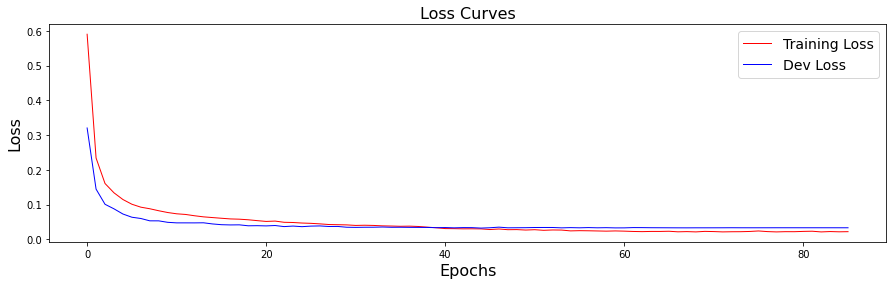

In [21]:
%matplotlib inline
plt.figure(figsize=[15, 4])
plt.plot(loss_df['TRAIN_LOSS'], 'r', linewidth=1.0)
plt.plot(loss_df['DEV_LOSS'], 'b', linewidth=1.0)
plt.legend(['Training Loss', 'Dev Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16);